In [123]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
MAX_TOWERS = 6
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack 
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import math

In [3]:
def get_train():
    train_main = pd.read_csv("../data/task1/train_1.8.csv", encoding="cp1251")
    train_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    train_aux_frac = pd.read_csv("../data/task1_additional/frac_train_1.csv", encoding="cp1251")
    train_aux_gdis = pd.read_csv("../data/task1_additional/gdis_train1.2.csv", encoding="cp1251")
    
    
    train_frac_main = pd.merge(train_main, train_aux_frac,how="left", left_on="Скважина", right_on="Скважина")
    all_recs = pd.merge(train_frac_main, train_aux_gdis,how="left", left_on="Скважина", right_on="Скважина").reset_index()
    
    return all_recs

def get_test():
    test_main = pd.read_csv("../data/task1/test_1.9.csv", encoding="cp1251")
    test_aux_coords = pd.read_csv("../data/task1_additional/coords_train_1.1.csv", encoding="cp1251")
    test_aux_frac = pd.read_csv("../data/task1_additional/frac_test_1.csv", encoding="cp1251")
    test_aux_gdis = pd.read_csv("../data/task1_additional/gdis_test1.2.csv", encoding="cp1251")
    
    
    test_frac_main = pd.merge(test_main, test_aux_frac,how="left", left_on="Скважина", right_on="Скважина")
    all_recs = pd.merge(test_frac_main, test_aux_gdis,how="left", left_on="Скважина", right_on="Скважина").reset_index()
    return all_recs

In [4]:
#sort by converted date and group
def convert_and_sort(df):
    df["Дата"] =  df["Дата"].apply(pd.to_datetime)
    return df.sort_values(by=["Скважина", "Дата"])

def get_non_useful(df):
    non_useful_columns = []
    for c in df.columns:
        null_columns = df[df[c].isnull()]
        if len(null_columns)== len(df):
            non_useful_columns.append(c)
    return non_useful_columns

def drop_non_useful(train, test):
    non_useful = set(get_non_useful(train)) |set(get_non_useful(test))
    print("%s dropped"% non_useful)
    return train.drop(list(non_useful), axis=1), test.drop(list(non_useful), axis=1)

def get_float(v):
    v = str(v)
    if v != "NaN":
        new = v.replace(",",".")
        return float(new)
    return v

def get_target(df, column="Нефть, т"):
    target = df[column]
    print("%s dropped"% column)
    return df.drop([column], axis=1), target.apply(get_float)

#drop non present columns in test
def drop_not_present(train, test):
    absent_columns = list(set(train.columns) - set(test.columns))
    print("%s dropped"% absent_columns)
    return train.drop(absent_columns, axis=1), test
    
def show_uniq_test_train(train, test):
    #check all values that have zero ans nan only
    for c in sorted(train.columns):
        un = train[c].unique()
        if len(un)<100:
            tun = test[c].unique()
            print("%s ;train: %s; test:%s"%(c, un, tun))

In [5]:
show_uniq_test_train(train, test)

NameError: name 'train' is not defined

In [10]:
def common_data_pipeline(train, test):
    y = None
    train=convert_and_sort(train)
    train, test = drop_non_useful(train, test)
    #remove target from train
    train, y = get_target(train)
    train, test = drop_not_present(train, test)
    print(train.shape)
    print(test.shape)
    
    return train, test, y

In [11]:
def get_existed(columns, df):
    return list(set(columns)&set(df.columns))

def split_continious_date_categorical_text(df):
    group_id = ["Скважина"]
    text = ["Причина простоя"]
    categorical = ["Тип испытания",
                   "Тип скважины",
                 #  "Неустановившийся режим",
                   "ГТМ",
                   "Метод",
                   "Характер работы",
                   "Состояние",
                   "Пласт МЭР", 
                   "Способ эксплуатации", 
                   "Тип насоса", 
                   "Состояние на конец месяца", 
                   "Номер бригады", 
                  # "Фонтан через насос", 
                   "Нерентабельная",
                   "Назначение по проекту",
                  # "Группа фонда",
                   "Тип дополнительного оборудования",
                   "Марка ПЭД",
                   "Тип ГЗУ",
                   "ДНС",
                   "КНС",
                   #useless potentially
                 # "Диаметр плунжера",
                  # "Природный газ, м3",
                   #"Конденсат, т",
                  #"Длина хода плунжера ШГН",
                   #"Коэффициент подачи насоса",
                   #"Дебит конденсата",
                   #"Вязкость воды в пластовых условиях",
                   #"Газ из газовой шапки, м3",
                   #"Число качаний ШГН",
                   "Коэффициент сепарации",
                   "SKIN",
                   #"КН закрепленный",
                   # radically different
                   "Время в работе",
                   "Радиус контура питания",
                   "Время в накоплении",
                   "Время накопления",
                   "Агент закачки",
                   # text converted
                   "Мероприятия",
                   "Проппант",
                   "Куст",
                   "Состояние на конец месяца",
                   "Причина простоя.1",
                   ]
    dates = ["Дата", 
             "Дата ГРП",
             "Время до псевдоуст-ся режима", 
             "Дата пуска",
             "Дата останова",
             ]
    exclude_cont = ['Ток номинальный', 'Приемистость, м3/сут',
       'Глубина верхних дыр перфорации', 'Пластовое давление начальное', 'Низ',
       'I X/X', 'Обводненность (вес), %', 'ГП - Забойное давление',
       'ТП - Забойное давление', 'FCD', 'Простой, ч', 'М пр', 'JD',
       'Буферное давление', 'Мощность ПЭД', 'Обводненность',
       'Пластовое давление', 'М бр', 'Глубина спуска',
       'Производительность ЭЦН', 'JD факт', 'Рпл Хорнер', 'К пр от стимуляции',
       'Xf', 'Закачка, м3', 'Давление в линии', 'Диаметр НКТ',
       'ГП(ГРП) Дебит жидкости', 'ГП(ГРП) Дебит жидкости скорр-ый', 'Эфф',
       'Напор', 'Верх', 'Азимут', 'Диаметр экспл.колонны', 'Ток рабочий',
       'Затрубное давление', 'Hf', 'Wf',
                   "Дата ввода в эксплуатацию",
                   "Дата запуска после КРС" ,
                   "Диаметр плунжера",
                   "Природный газ, м3",
                   "Конденсат, т",
                   "Длина хода плунжера ШГН",
                   "Коэффициент подачи насоса",
                   "Дебит конденсата",
                   "Вязкость воды в пластовых условиях",
                   "Газ из газовой шапки, м3",
                   "Число качаний ШГН",
                   "Группа фонда",
                   "Фонтан через насос",
                   "Неустановившийся режим",
                   "Закачка, м3",
                   "ГП(ИДН) Прирост дефита нефти",
                   "Вязкость нефти в пластовых условия",
                   "Закачка, м3",
                   "ГП(ИДН) Дебит жидкости скорр-ый",
                   ]
                   
    continious = list(set(df.columns) - set(dates) - set(categorical) - set(text) - set(group_id) - set(exclude_cont))
    return (df[group_id],df[continious], df[get_existed(dates,df)], df[get_existed(categorical, df)],
            df[get_existed(text, df)])

In [43]:
def get_object_columns(df):
    objects = []
    for c in df.columns:
        if df[c].dtype != pd.np.float:
            objects.append(c)
    return objects

def convert_locale_to_float(df):
    loc_float = get_object_columns(df)
    converted = df.copy()
    for c in loc_float:
        converted.loc[:,c] = df[c].apply(get_float)
    return converted
        
def fill_with_mean(train, test):
    means=train.mean()
    norm_train = train.fillna(means)
    norm_test = test.fillna(means)
    return norm_train, norm_test

# now we have clear non-normalized data, let's normalize first
def normalize(train, test):
    scaler = StandardScaler()
    norm_train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
    norm_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index = test.index)
    return norm_train, norm_test

def get_fold():
    return KFold(n_splits = 4,shuffle=True, random_state = 17)

In [44]:
def cont_transform_pipeline(train, test):
    train_f = convert_locale_to_float(train)
    test_f = convert_locale_to_float(test)
    train_cont, test_cont = fill_with_mean(train_f, test_f)
    train_cont, test_cont = normalize(train_cont, test_cont)
    print(train_cont.isnull().values.any() or test_cont.isnull().values.any())
    return train_cont, test_cont

In [45]:
def transform_cats_to_labels(train_cat, test_cat):
    transformed_df = train_cat.copy()
    trans_test = test_cat.copy()
    train_oh = []
    test_oh = []
    for c in train_cat.columns:
        encoder = LabelEncoder()
        one_hot = OneHotEncoder(sparse=False)
        column_train = train_cat[c].astype(str)
        column_test = test_cat[c].astype(str)
        combined = pd.concat([column_train, column_test])
        encoder.fit(combined)
        cl_index = np.reshape(list(range(len(encoder.classes_))),(-1,1))
        one_hot.fit(cl_index)
        train_labels = encoder.transform(column_train).reshape(-1,1)
        transformed_df[c] = train_labels
        train_oh.append(one_hot.transform(train_labels))
        test_labels = encoder.transform(column_test).reshape(-1,1)
        trans_test[c] = test_labels
        test_oh.append(one_hot.transform(test_labels))
    train_oh = pd.DataFrame(np.hstack(train_oh), index = train_cat.index)
    test_oh = pd.DataFrame(np.hstack(test_oh), index = test_cat.index)
    return transformed_df, trans_test, train_oh, test_oh

In [46]:
def cat_transform_pipeline(train, test):
    return transform_cats_to_labels(train, test)

In [47]:
def text_trasnsform_pipeline(train, test):
    if "Причина простоя" in train.columns:
        train_txt = train["Причина простоя"].str.lower()
        test_txt = test["Причина простоя"].str.lower()
        return train_txt, test_txt
    return train, test

In [48]:
def transform_dates_into_order(dates, group):
    grouped = pd.concat([dates, group], axis=1)
    idx = []
    orders = []
    for name,group in grouped.groupby(["Скважина"]):
        index = group.index
        for i in range(len(index)):
            idx.append(index[i])
            orders.append(i)
    ord_index = pd.Index(idx)
    ordered_fr = pd.Series(orders, index=ord_index, dtype="int32",name="order")
    return ordered_fr

def dates_transform_pipeline(train, test, train_group):
    train_cont = train.drop(["Дата"], axis =1)
    train_cat = train["Дата"].apply(pd.to_datetime)
    train_cat = transform_dates_into_order(train_cat, train_group)
    test_cont = test.drop(["Дата"], axis =1)
    test_cat = test["Дата"].apply(pd.to_datetime)
    test_cat = pd.Series(0, index=test_cat.index, dtype="int32", name="order")
    return train_cont, test_cont, train_cat, test_cat

In [49]:
def clean_non_targeted(train_array, y_train, dates_ord=None):
    clean_array = []
    train_array.append(y_train)
    #clear nans in target
    indexes_to_delete = y_train[(y_train.isnull())|(y_train==0)].index
    if dates_ord is not None:
        dates_index = dates_ord[dates_ord>=6].index
        indexes_to_delete = indexes_to_delete.union(dates_index)
    for df in train_array:
        item = df.drop(index=indexes_to_delete)
        clean_array.append(item)
        print(item.shape)
    return clean_array

In [50]:
def get_preds_for_cats(train, test, y, cat_features):
    print("start catboost")
    cb_regressor = CatBoostRegressor(logging_level="Silent", random_state=17)
    train_catboost_preds = cross_val_predict(cb_regressor, train, y)
    cb_regressor.fit(train,y=y, cat_features=cat_features)
    test_catboost_preds = pd.Series(cb_regressor.predict(test), index=test.index)
    print("finish catboost")
    return train_catboost_preds, test_catboost_preds

In [144]:
def get_cont_ensemble():
    print("start ensemble")
    ridge = Ridge(random_state=17)
    rtree = RandomForestRegressor(n_jobs=-1, n_estimators=150, random_state=17)
    svr = LinearSVR(random_state=17)
    xgboost = xgb.XGBRegressor(n_estimators=200, max_depth=5, random_state=17)
    nn = MLPRegressor(max_iter=500, random_state=17)
    et = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, random_state=17)
    lass = Lasso(random_state=17)
    return [ridge, rtree, xgboost]

def get_cont_ensemble_names():
    return ["ridge", "rtree", "xgboost"]

In [66]:
def get_meta_train_preds(X, y, train_mixture, mix_cols):
    predicts = []
    for cl in get_cont_ensemble():
        predicts.append(cross_val_predict(cl, X,y, n_jobs=-1, cv=get_fold()))
    predicts.append(train_mixture)
    return pd.DataFrame(np.vstack(predicts).transpose(), index=y.index, columns=get_cont_ensemble_names()+mix_cols)

def get_meta_test_predict(X_train, y_train, X_test, test_mixture, mix_cols):
    test_predicts = []
    
    for i,cl in enumerate(get_cont_ensemble()):
        print("%s:%s"%(i,cross_val_score(cl, X_train, y_train, n_jobs=-1, scoring="neg_mean_absolute_error", cv=get_fold())))
        cl.fit(X_train, y_train)
        pr = cl.predict(X_test)
        test_predicts.append(pr)
    test_predicts.append(test_mixture)
    #add svd predicts
    return  pd.DataFrame(np.vstack(test_predicts).transpose(), index=X_test.index, columns=get_cont_ensemble_names()+mix_cols)

def get_stacked_ensemble_predict(X_meta, y, X_test):
    regressor = xgb.XGBRegressor(random_state=17)
    regressor.fit(X_meta, y)
    return pd.DataFrame(regressor.predict(X_test), index=X_test.index)

In [53]:
def get_n_item_index(group_size, df, group):
    new_df = pd.concat([df, group], axis = 1)
    index = []
    group = new_df.groupby(["Скважина"])
    for name, group in group:
        if len(group)<group_size:
            continue
        for start in range(len(group.index) - group_size):
            gr =group.index[start:start+group_size]
            index.append(gr)
    return index

def get_timed_ds(meta_size, df, group, y):
    if meta_size >= 1:
        meta_indexes = get_n_item_index(meta_size, df, group)
        first_value_idx = []
        timed_ds = df.copy()
        metas = []
        columns = []
        for i in range(meta_size):
            columns.append("meta%s"%str(i))
        for a in meta_indexes:
            first_value_idx.append(a[0])
            metas.append(list(y.loc[a]))
        metas_df = pd.DataFrame.from_records(metas, index=first_value_idx, columns=columns)
        return pd.concat([timed_ds.loc[first_value_idx], metas_df], axis=1)
    elif meta_size == 0:
        return df
    
def get_n_tower_predictions(n, train, y, test, train_group, train_mix, test_mix, mix_col,):
    X_meta_train = get_meta_train_preds(train, y, train_mixture=train_mix, mix_cols=mix_col)
    X_meta_test = get_meta_test_predict(train, y, test, test_mixture=test_mix, mix_cols=mix_col)
    test_predictions= []
    for i in range(0,n):
        train_timed_ds = get_timed_ds(i,X_meta_train, train_group, y)
        y_timed = y.loc[train_timed_ds.index]
        test_predict = get_stacked_ensemble_predict(train_timed_ds, y_timed,X_meta_test)
        test_predictions.append(test_predict)
        X_meta_test["meta%s"%i]=test_predict
    return pd.concat(test_predictions,axis=1)

In [54]:
def create_submission(fname, df):
    final_pred = pd.Series(df)
    final_pred.to_csv(fname,header=["_VAL_"],index_label=["_ID_"])

In [55]:
def check_passed(to_test, df):
    for c in df.columns:
        if df[c].corr(to_test)>0.8:
            return False
    return True
    
def square_cont(train, test, y):
        columns = []
        train_squared = []
        print("started squaring")
        for c1 in train.columns:
            for c2 in train.columns:
                name = str(c1)+"1_"+str(c2)+"2"
                sq_item = train[c1].multiply(train[c2])
                sq_item.rename(name, inplace=True)
                corr = sq_item.corr(y)
                if (corr >0.1 or corr<-0.1)  and check_passed(sq_item, train):
                    columns.append((c1,c2))
                    train_squared.append(sq_item)
        print("finish squaring")
        test_squared = []
        for c1, c2 in columns:
            name = str(c1)+"1_"+str(c2)+"2"
            sq_item = test[c1].multiply(test[c2])
            sq_item.rename(name, inplace=True)
            test_squared.append(sq_item)
        return pd.concat(train_squared, axis=1), pd.concat(test_squared, axis = 1)

In [56]:
def  sqrt(x):
    if np.all(x>0):
        return np.sqrt(x)
    return 0
def reverse(x):
    if np.all(x!=0):
        return 1/x
    return 0

def log(x):
    if np.all(x>0):
        return np.log(x)
    return 0

transformations = {"log":log, 
                   "exp":np.exp, 
                   "sqrt":sqrt,
                   "sq":lambda x: x**2, 
                   "cube":lambda x:x**3,
                   "reverse":reverse,
                   "orig":lambda x:x}

def get_max_correlation(x,y):
    max_corr = 0
    max_corr_fn = "orig"
    for n,tf in transformations.items():
        x_tf = x.apply(tf)
        corr = abs(y.corr(x_tf))
        if corr>max_corr:
            max_corr = corr
            max_corr_fn  = n
    return max_corr_fn

def transform_with_max_corr(train, test, y):
    for c in train.columns[:150]:
        fn = get_max_correlation(train[c], y)
        if fn != "orig":
            train.loc[:,c] = train[c].apply(transformations[fn])
            test.loc[:,c] = test[c].apply(transformations[fn])
    return train, test

In [215]:
def transform_target(target):
    return target.apply(np.log1p)

In [216]:
def get_clean_data(train, test):
    train, test, y_train  = common_data_pipeline(train, test)
    train_group, train_cont, train_dat, train_cat, train_text = split_continious_date_categorical_text(train)
    test_group, test_cont, test_dat, test_cat, test_text = split_continious_date_categorical_text(test)
    train_dat_cont, test_dat_cont, train_dat_cat, test_dat_cat = dates_transform_pipeline(
        train_dat, test_dat, train_group)
    train_text, test_text = text_trasnsform_pipeline(train_text, test_text)
    train_cat = pd.concat([train_cat, train_dat_cat, train_text], axis = 1)
    test_cat = pd.concat([test_cat, test_dat_cat, test_text], axis = 1)
    
    #train_cont, test_cont = cont_transform_pipeline(train_cont, test_cont)
    #train_cont, test_cont = transform_with_max_corr(train_cont, test_cont, y_train)
    
    train_cont = pd.concat([train_cont, train_dat_cont], axis = 1)
    test_cont = pd.concat([test_cont, test_dat_cont], axis = 1)
    train_cont, test_cont = cont_transform_pipeline(train_cont, test_cont)
    
    train_cat, test_cat, train_cat_oh, test_cat_oh = cat_transform_pipeline(train_cat, test_cat)
    train_cont = pd.concat([train_cont, train_cat_oh], axis = 1)
    test_cont = pd.concat([test_cont, test_cat_oh], axis=1)
    
    train_cont, train_group, train_cat, y_train = clean_non_targeted([train_cont, train_group, train_cat], y_train, train_dat_cat)
    y_train  = transform_target(y_train)
    # merge cont into cat to get better result
    train_cat_preds, test_cat_preds = get_preds_for_cats(pd.concat([train_cat, train_cont], axis=1),
                                                         pd.concat([test_cat, test_cont], axis=1), 
                                                         y_train,
                                                        cat_features = list(range(len(train_cat.columns))))
    return train_cont, y_train, test_cont, train_group, train_cat_preds, test_cat_preds

In [217]:
def get_prediction(train, test, constant = 701.4750):
    np.random.seed(17)
    random.seed(17)
    train_cont, y_train, test_cont, train_group, train_cat_preds, test_cat_preds = get_clean_data(train,test)
    y_train = transform_target(y_train)
    time_serie_pred = get_n_tower_predictions(
        6, train_cont, y_train,test_cont, train_group, train_cat_preds, test_cat_preds, ["catboost"]
    ).values.reshape(-1,1)
    time_serie_pred = np.squeeze(time_serie_pred)
    print(np.log(constant) - np.mean(time_serie_pred))
    final_pred = time_serie_pred
    return final_pred

In [218]:
preds = get_prediction(get_train(), get_test())

{'Тип газосепаратора', 'Фирма ГРП', 'Станок-качалка', 'Агент закачки', 'Примечание'} dropped
Нефть, т dropped
['Дебит жидкости', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости', 'Жидкость, м3', 'Нефть, м3'] dropped
(5729, 134)
(319, 134)
False
(2330, 744)
(2330, 1)
(2330, 30)
(2330,)
start catboost
finish catboost
start ensemble
start ensemble
0:[-0.07871947 -0.07482149 -0.08162984 -0.07595908]
1:[-0.01272784 -0.01237607 -0.01570777 -0.01251777]
2:[-0.0109251  -0.01181684 -0.01421747 -0.01097431]
4.732778585649979


In [208]:
np.mean(preds)

1.8204067

In [227]:
def untransform(e,  constant = 701.4750):
    preds = np.exp(e) - 1
    preds = preds+ (constant - np.mean(preds))
    return preds
preds_final = untransform(preds)
preds_final

array([701.1739 , 701.1708 , 701.1467 , ..., 700.4031 , 700.3706 ,
       700.33856], dtype=float32)

In [226]:
create_submission("all_data_log_linear_corrected.csv", preds_final)

In [ ]:
242.30233154296877
242.30233154296877

In [153]:
def get_cleaned_test(test, size=6):
    test, y_test = get_target(test)
    test, y_test = clean_non_targeted([test], y_test)
    X_idx = []
    y_idx = []
    group = test.groupby(["Скважина"])
    for name, group in group:
        if len(group)!= size:
            continue
        X_idx.append(group.index[0])
        y_idx.extend(group.index)
    if X_idx and y_idx:
        test = test.loc[X_idx]
        y_test = y_test[y_idx]
        y_test = transform_target(y_test)
        constant = np.mean(y_test.values)
        return test, y_test, constant
    else:
        return None, None, None

In [154]:
def cross_validate(train, n_folds = 4):
    errors = []
    k_fold = KFold(n_splits=n_folds, random_state=17, shuffle=True)
    for tr_ix, test_ix in k_fold.split(train):
        print("new fold started")
        train_cv = train.iloc[tr_ix]
        test_cv = train.iloc[test_ix]
        test_cv, y_test, constant = get_cleaned_test(test_cv)
        test_preds = get_prediction(train_cv, test_cv, constant=constant)
        error=mean_absolute_error(y_true=y_test, y_pred=test_preds)
        print("fold error:%s" % error)
        errors.append(error)
    print("overall error: %s" % np.mean(errors))
    print(errors)

In [155]:
cross_validate(get_train())

new fold started
Нефть, т dropped
(1109, 147)
(1109,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Вязкость воды в пластовых условиях', 'Мероприятия', 'Время в работе', 'ТП - JD опт.', 'ГП(ИДН) Прирост дефита нефти', 'Неустановившийся режим', 'Дата запуска после КРС', 'Затрубное давление', 'Диаметр дополнительного оборудования', 'ГП(ГРП) Дебит жидкости скорр-ый', 'К пр от стимуляции', 'Вязкость жидкости в пласт. условиях', 'ГП - Забойное давление', 'Газовый фактор', 'Глубина спуска.1', 'SKIN', 'Удлинение', 'Куст', 'Давление на приеме', 'ТП - SKIN', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Частота', 'ГП(ГРП) Дебит жидкости', 'Удельный коэффициент', 'Диаметр НКТ', 'Вязкость нефти в пластовых условиях', 'Фонтан через насос', 'ТП(ГРП) Дебит жидкости', 'Агент закачки', 'Дата останова', 'Число качаний ШГН', 'Пластовое давление начальное', 'Дата ввода в эксплуатацию', 'Группа фонда', 'Дата ГРП', 'ТП - Забойное давление', 'Номер бригады', 'Буферное давление', 'ГП - Общий прирост Qн', 'Время до псевдоуст-ся режима', 'Способ эксплуатации', 'Радиус контура питания', 'КВЧ', 'Пласт МЭР', 'Причина п

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Мероприятия', 'Тип газосепаратора', 'Фирма ГРП', 'Станок-качалка', 'Агент закачки', 'Примечание', 'Причина простоя.1', 'Тип дополнительного оборудования', 'Дата ГРП', 'Марка ПЭД'} dropped
Нефть, т dropped
[] dropped
(4297, 137)
(7, 137)
False
(2023, 620)
(2023, 1)
(2023, 26)
(2023,)
start catboost
finish catboost
start ensemble
start ensemble
0:[-0.07393473 -0.07789584 -0.07014638 -0.07451456]
1:[-0.00147336 -0.00230098 -0.00173566 -0.00287167]
2:[-0.00212968 -0.00209714 -0.00232048 -0.00242289]
4.501086225872004
fold error:0.46891223857426984
new fold started
Нефть, т dropped
(1112, 147)
(1112,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Мероприятия', 'Тип газосепаратора', 'Фирма ГРП', 'Станок-качалка', 'Агент закачки', 'Примечание', 'Причина простоя.1', 'Тип дополнительного оборудования', 'Марка ПЭД'} dropped
Нефть, т dropped
[] dropped
(4297, 138)
(21, 138)
False
(2068, 628)
(2068, 1)
(2068, 26)
(2068,)
start catboost
finish catboost
start ensemble
start ensemble
0:[-0.07362023 -0.07673882 -0.07617429 -0.07472531]
1:[-0.00171197 -0.00257213 -0.00187685 -0.00146715]
2:[-0.00211373 -0.00275994 -0.00218529 -0.00211425]
3.95335931015536
fold error:0.9269136348798445
new fold started
Нефть, т dropped
(1136, 147)
(1136,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Мероприятия', 'Тип газосепаратора', 'Фирма ГРП', 'Станок-качалка', 'Агент закачки', 'Примечание', 'Причина простоя.1', 'Тип дополнительного оборудования', 'КНС', 'Марка ПЭД'} dropped
Нефть, т dropped
[] dropped
(4297, 137)
(14, 137)
False
(2051, 611)
(2051, 1)
(2051, 25)
(2051,)
start catboost
finish catboost
start ensemble
start ensemble
0:[-0.07098009 -0.0792997  -0.07769244 -0.07588883]
1:[-0.00149252 -0.00266879 -0.00195477 -0.00204485]
2:[-0.00192208 -0.00218869 -0.00213608 -0.00191374]
4.149538948092173
fold error:0.693582698392
overall error: 0.8513609468749455
[1.3160352156536677, 0.46891223857426984, 0.9269136348798445, 0.693582698392]


In [27]:
299.720573012412
[289.9811313784219, 335.9357574203388, 126.81710257918746, 446.1483006716997]
300.25068988386926
[290.65788832253554, 336.1340891623984, 127.1327437987151, 447.07803825182793]
300.18614828409784
[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]
285.9852514405545
[267.45969725620597, 281.4598397521973, 81.43385848363239, 513.5876102701824]
260.7050305503842
[285.48734338760374, 240.13236792105218, 238.9836193061597, 226.74571254057042, 312.176109596535]
294.66398402441115
[240.20572041829428, 346.64098253522604, 298.8145652553014, 292.994667888823]
295.00947591811894
[240.35139353434244, 347.16105438232427, 298.9804015289791, 293.54505422682985]
295.90190843312
[241.25445229554788, 348.402697652181, 299.64674013168093, 294.30374365307034]
295.3792892683586
[241.22872128217648, 347.65355759393606, 299.4774894011967, 293.15738879612513]
295.1825753026131
[241.04178057548327, 346.85150514148535, 299.4132816278367, 293.4237338656471]
294.9022548526955
[241.1999166009365, 345.8461416771299, 299.4364936368428, 293.1264674958728]
293.59822052331515
[240.6871044182667, 345.6373588043017, 298.5003662020143, 289.5680526686779]
295.0485831301902
[242.15174558199368, 345.12844017392115, 299.55880542573476, 293.3553413391113]
295.3146868490794
[241.1199405924479, 347.18048281715033, 299.70953150189115, 293.2487924848284]
295.39453709307753
[242.4517316143329, 345.3109058634441, 299.8078347972083, 294.0076760973249]
295.9224823257018
[242.46150878123748, 346.54313555036276, 300.30083731030663, 294.38444766090026]
#logarithmic
0.8513609468749455
[1.3160352156536677, 0.46891223857426984, 0.9269136348798445, 0.693582698392]

[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]

# eda part

In [222]:
train = get_train()
test = get_test()
train_group = train["Скважина"]
y_train = train["Нефть, т"]
y_train = y_train.fillna(0).apply(get_float)
y_train = y_train[y_train!=0]

In [239]:
from scipy.stats import boxcox
trf, lamb = boxcox(y_train, )
normaltest(trf)

NormaltestResult(statistic=51.69326903488585, pvalue=5.955925453168468e-12)

(array([314., 276., 182., 192., 175., 169., 211., 222., 153., 131., 159.,
        148., 137., 134., 145.,  88., 133.,  93., 102., 118.,  81.,  93.,
         91.,  74.,  76.,  70.,  48.,  38.,  84.,  48.,  45.,  32.,  37.,
         47.,  26.,  39.,  34.,  24.,  16.,  20.,  13.,  22.,  10.,  11.,
         16.,  18.,  10.,  13.,   6.,   2.,   6.,   5.,  10.,   7.,   3.,
          3.,   6.,   2.,   6.,   4.,   2.,   3.,   6.,   1.,   5.,   1.,
          1.,   0.,   5.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   2.,   4.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,
          1.]),
 array([1.00000e+00, 4.57700e+01, 9.05400e+01, 1.35310e+02, 1.80080e+02,
        2.24850e+02, 2.69620e+02, 3.14390e+02, 3.59160e+02, 4.03930e+02,
        4.48700e+02, 4.93470e+02, 5.38240e+02, 5.83010e+02, 6.27780e+02,
        6.72550e+02, 7.17320e+02, 7.62090e+02, 8.06860e+02, 8.51630e+02,
        8.96400e+02, 9.411

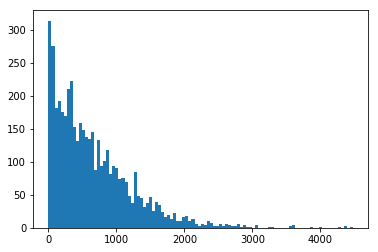

In [238]:
from scipy.special import inv_boxcox
plt.hist(inv_boxcox(trf, lamb,), bins=100)

In [90]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

In [100]:
y_train_clean.std()*2+y_train_clean.mean()

1926.3711875185631

In [91]:
mean_confidence_interval(y_train_clean)

(664.6835836909871, 639.0554059482205, 690.3117614337538)

In [228]:
from scipy.stats import normaltest
normaltest(y_train_clean.apply(np.log1p))

NormaltestResult(statistic=358.4390706494289, pvalue=1.465361440085136e-78)

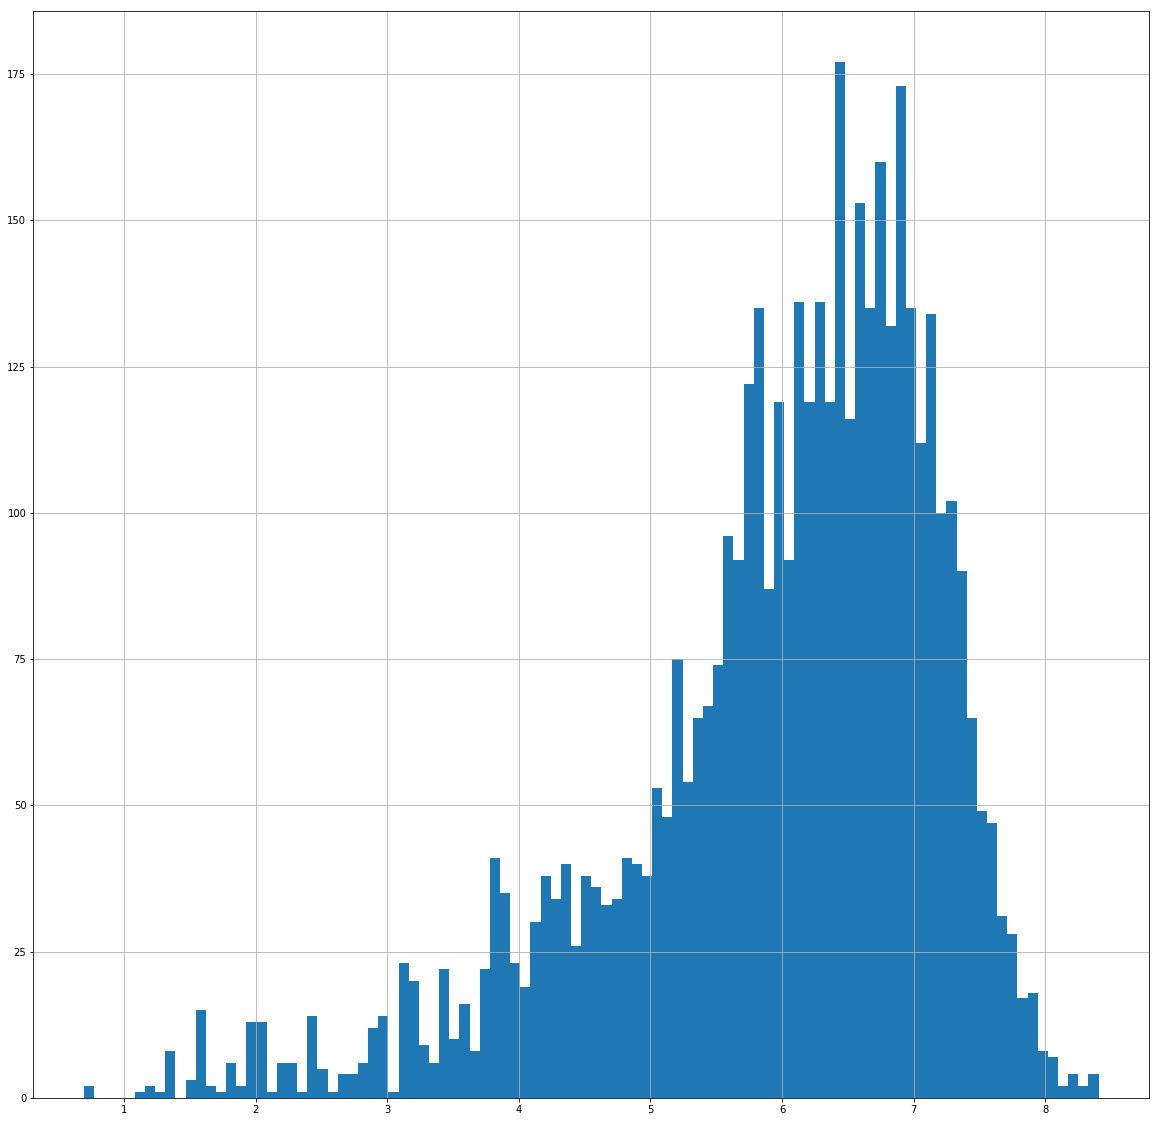

In [224]:
y_train.apply(np.log1p).hist(bins =100, figsize=(20,20))

In [68]:
train_cont, y_train_clean, test_cont, train_group, train_cat_preds, test_cat_preds = get_clean_data(train, test)

{'Тип газосепаратора', 'Фирма ГРП', 'Станок-качалка', 'Агент закачки', 'Примечание'} dropped
Нефть, т dropped
['Дебит жидкости', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ТП(ИДН) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости', 'Жидкость, м3', 'Нефть, м3'] dropped
(5729, 134)
(319, 134)
False
False
(2330, 744)
(2330, 1)
(2330, 30)
(2330,)
start catboost
finish catboost


In [69]:
y_train.shape

(4516,)

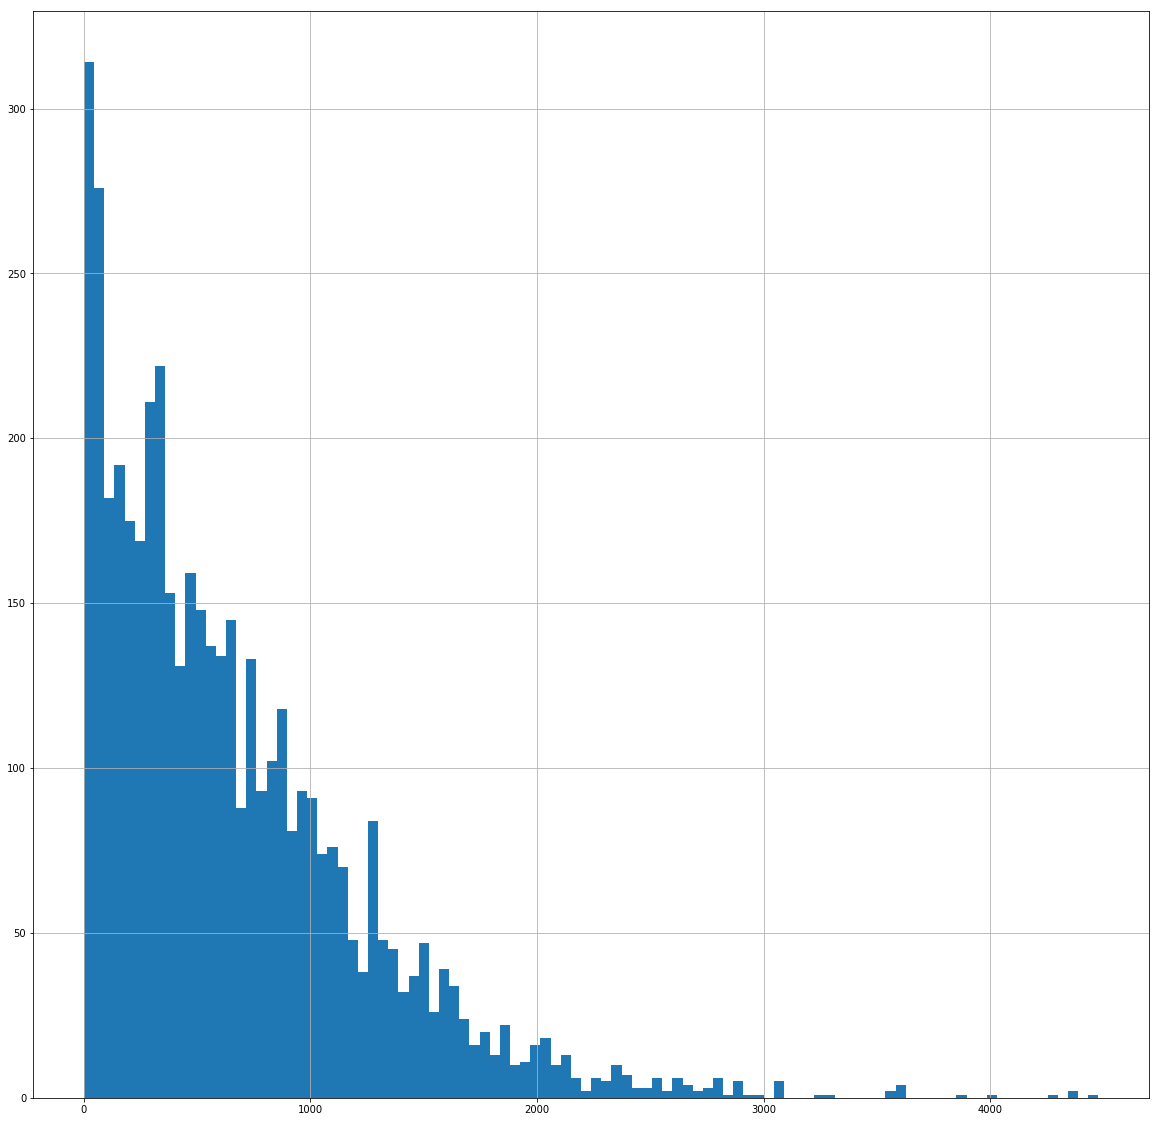

In [70]:
y_train.hist(bins =100, figsize=(20,20))

In [108]:
y_train[y_train>2000]

15      2345.15
56      2059.00
57      2059.00
152     2036.00
157     2424.00
158     2096.00
364     2017.00
365     2017.00
489     2080.00
490     2080.00
491     2080.00
787     2391.00
788     2339.00
789     2225.00
790     2009.00
1173    2233.02
1174    2041.98
1742    2807.57
1743    2296.01
1744    2916.76
1745    2860.57
1747    2070.04
1753    2316.95
1754    2178.56
1755    3994.73
1756    3584.35
1757    4277.30
1762    2132.89
1763    3862.49
1946    2382.00
1947    2184.00
2090    2281.00
2091    2281.00
2092    3552.00
2093    3552.00
2094    2877.00
2095    2877.00
2096    2089.00
2097    2089.00
2098    2369.00
2099    2369.00
2136    2523.00
2137    2523.00
2138    2381.00
2139    2381.00
2140    2003.00
2141    2003.00
2203    2036.00
2204    4478.00
2205    3621.00
2206    3288.00
2207    2544.00
2215    2337.00
2216    3255.00
2217    2730.00
2218    2875.00
2219    2470.00
2222    2250.00
2223    2154.00
2225    2541.00
2226    2760.00
2227    2760.00
2228    

In [73]:
dates_cont, dates_cont, dates_cat, _ = dates_transform_pipeline(train, test, train_group)

In [118]:
y_train_clean[train[train["Скважина"]== "6b68ae1be719488f259414bcb925ce37"].index]

/anaconda2/envs/env/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


2202       NaN
2203    2036.0
2204    4478.0
2205    3621.0
2206    3288.0
2207    2544.0
Name: Нефть, т, dtype: float64

Int64Index([2202, 2203, 2204, 2205, 2206, 2207], dtype='int64')

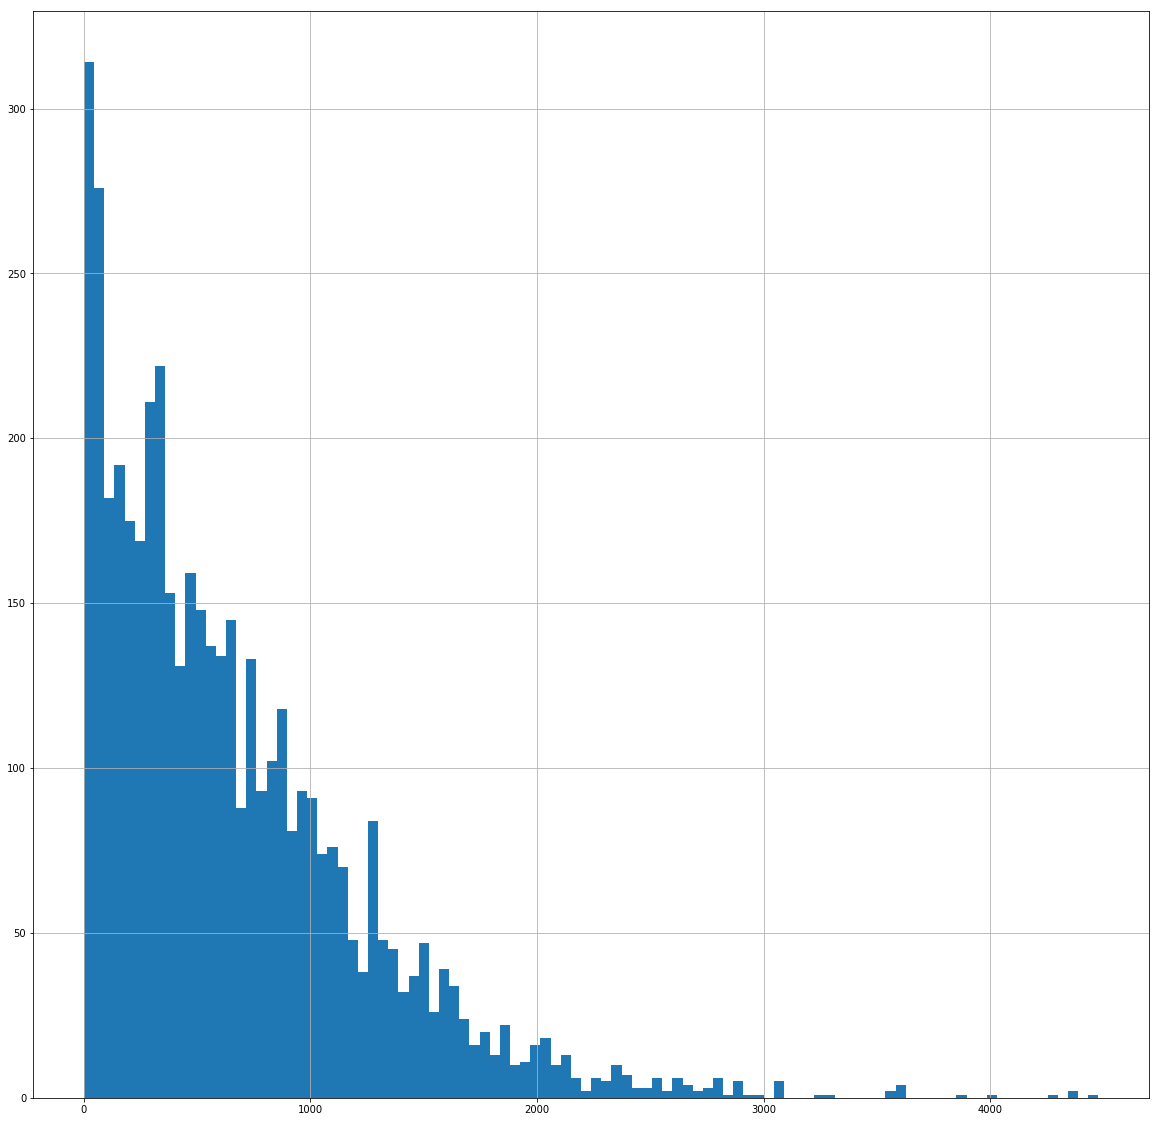

In [76]:
y_train.hist(bins =100, figsize=(20,20))
# распределение смещено в сторону нуля в реаль ности значения в два раза больше

In [75]:
y_train.unique()

array([ 278.55, 1074.74, 1046.8 , ...,  742.53,  697.43,  688.49])

In [55]:
len(y_train[y_train==0])

1044

In [58]:
len(dates_cat)

4764

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


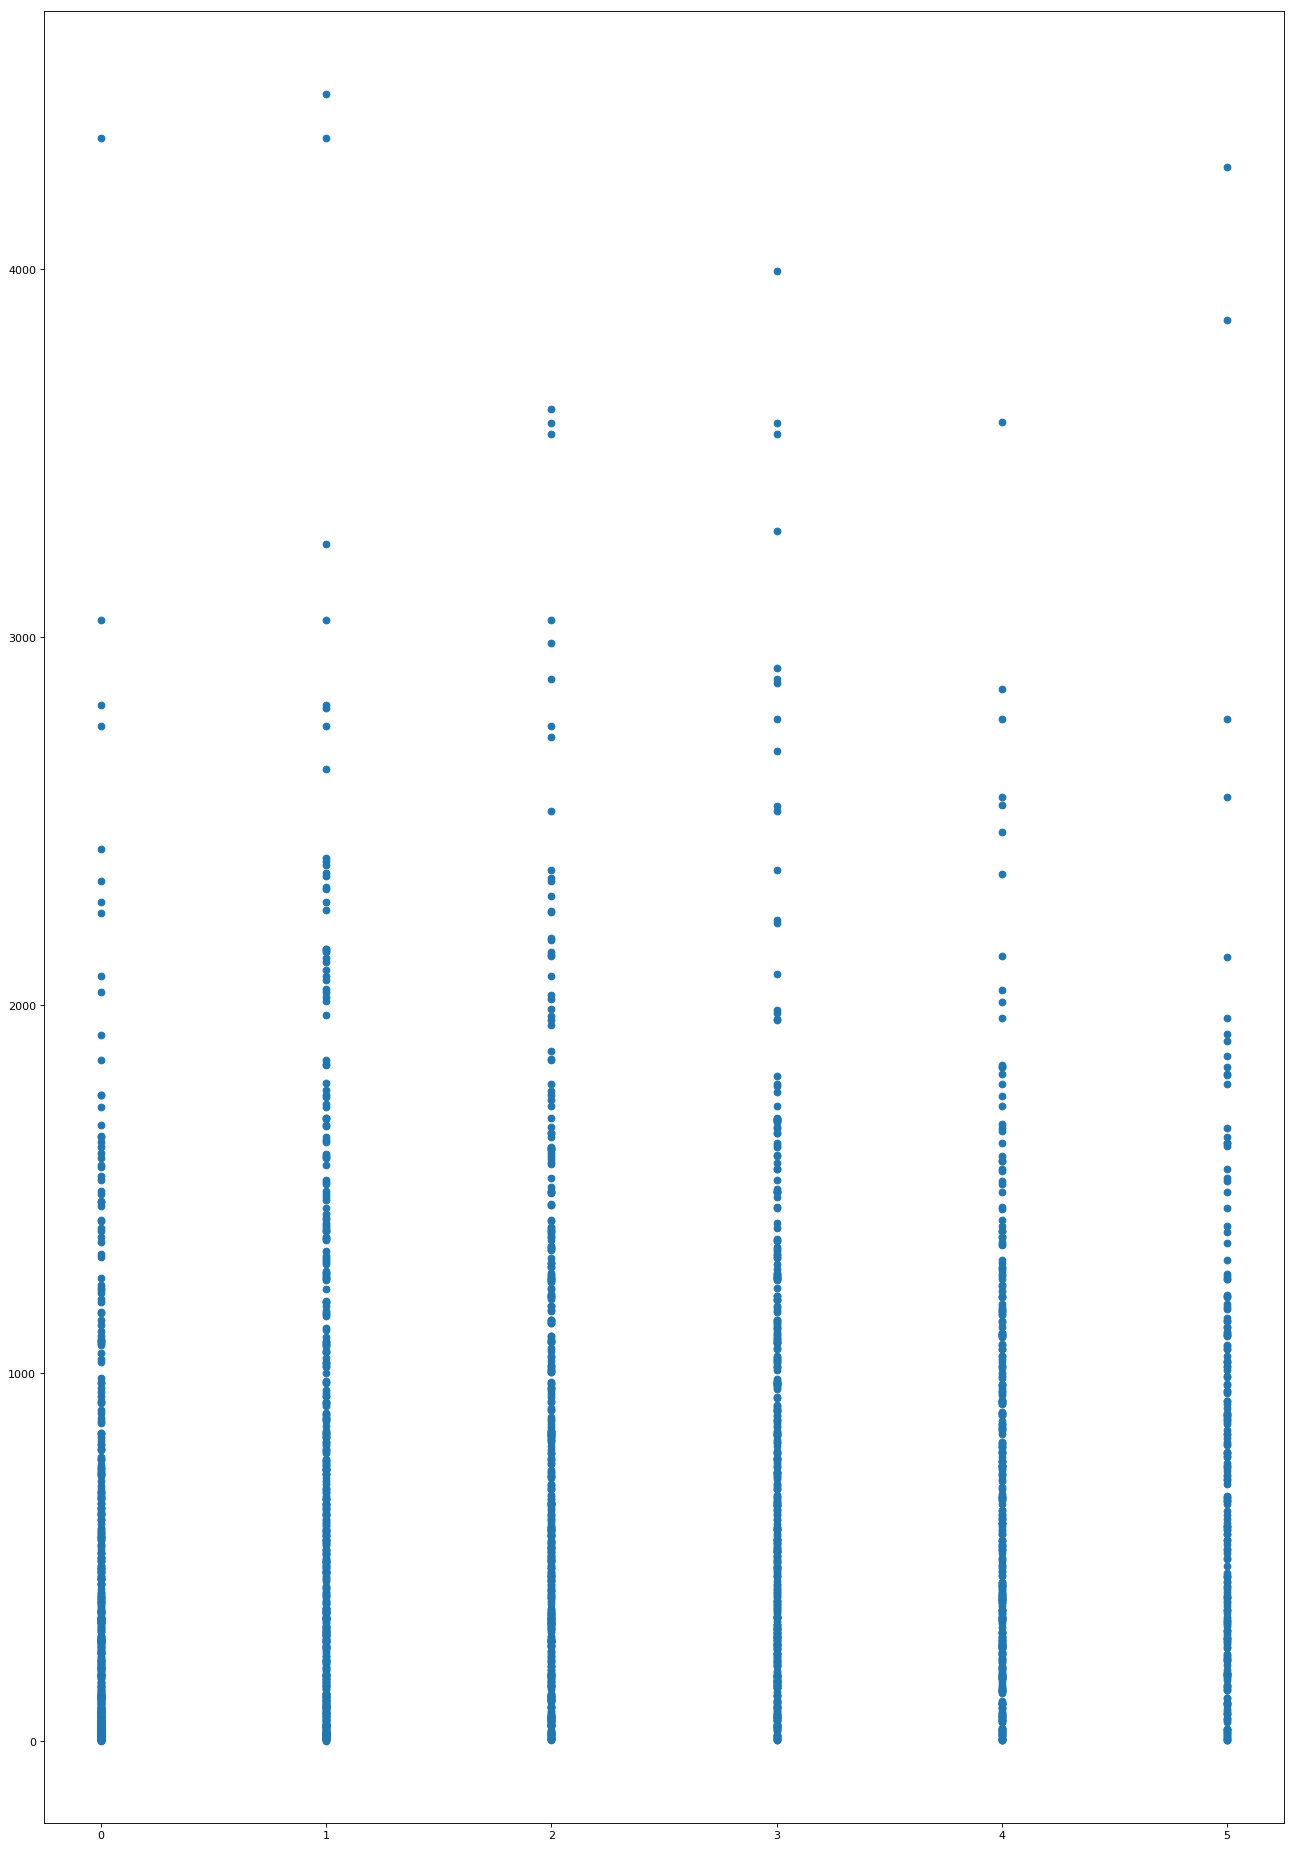

In [77]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 30), dpi=80)
plt.scatter(dates_cat.loc[y_train.index],y_train)

In [78]:
low_orders = dates_cat[dates_cat<6]

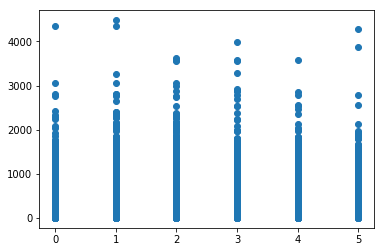

In [79]:
plt.scatter(dates_cat.loc[low_orders.index],y_train.loc[low_orders.index])

In [57]:
train = get_train()
test = get_test()
train_group = train["Скважина"]
y_train = train["Нефть, т"]

(5729, 147)
(319, 138)


In [58]:
dates_cont, dates_cont, dates_cat, _ = dates_transform_pipeline(train, test, train_group)

In [59]:
y_train = y_train.fillna(0).apply(get_float)

In [60]:
low_orders = dates_cat[dates_cat<6]

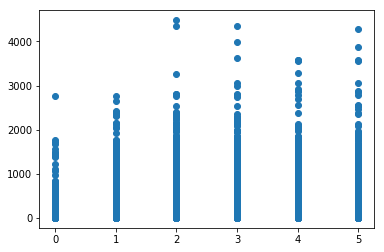

In [64]:
plt.scatter(dates_cat.loc[y_train.index],y_train)

In [62]:
y_train = y_train[low_orders.index]
y_train = y_train[y_train!=0]

In [63]:
y_train.mean()

664.6835836909871

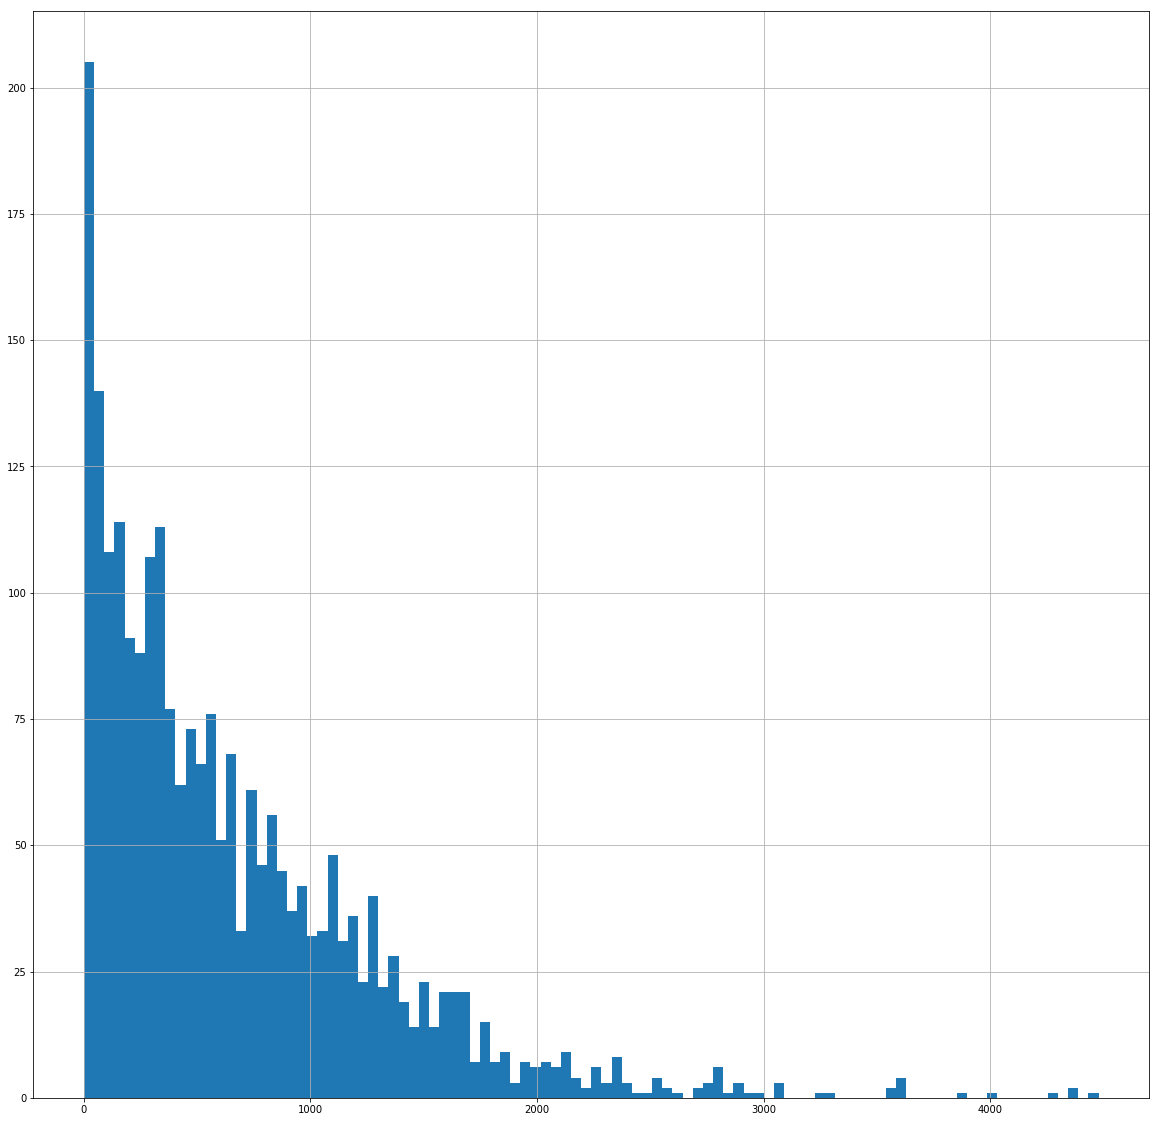

In [83]:
y_train.hist(bins =100, figsize=(20,20))

{'whiskers': [<matplotlib.lines.Line2D at 0x1a29906b70>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2990e470>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a29906a20>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2990ecc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a29917128>],
 'means': []}

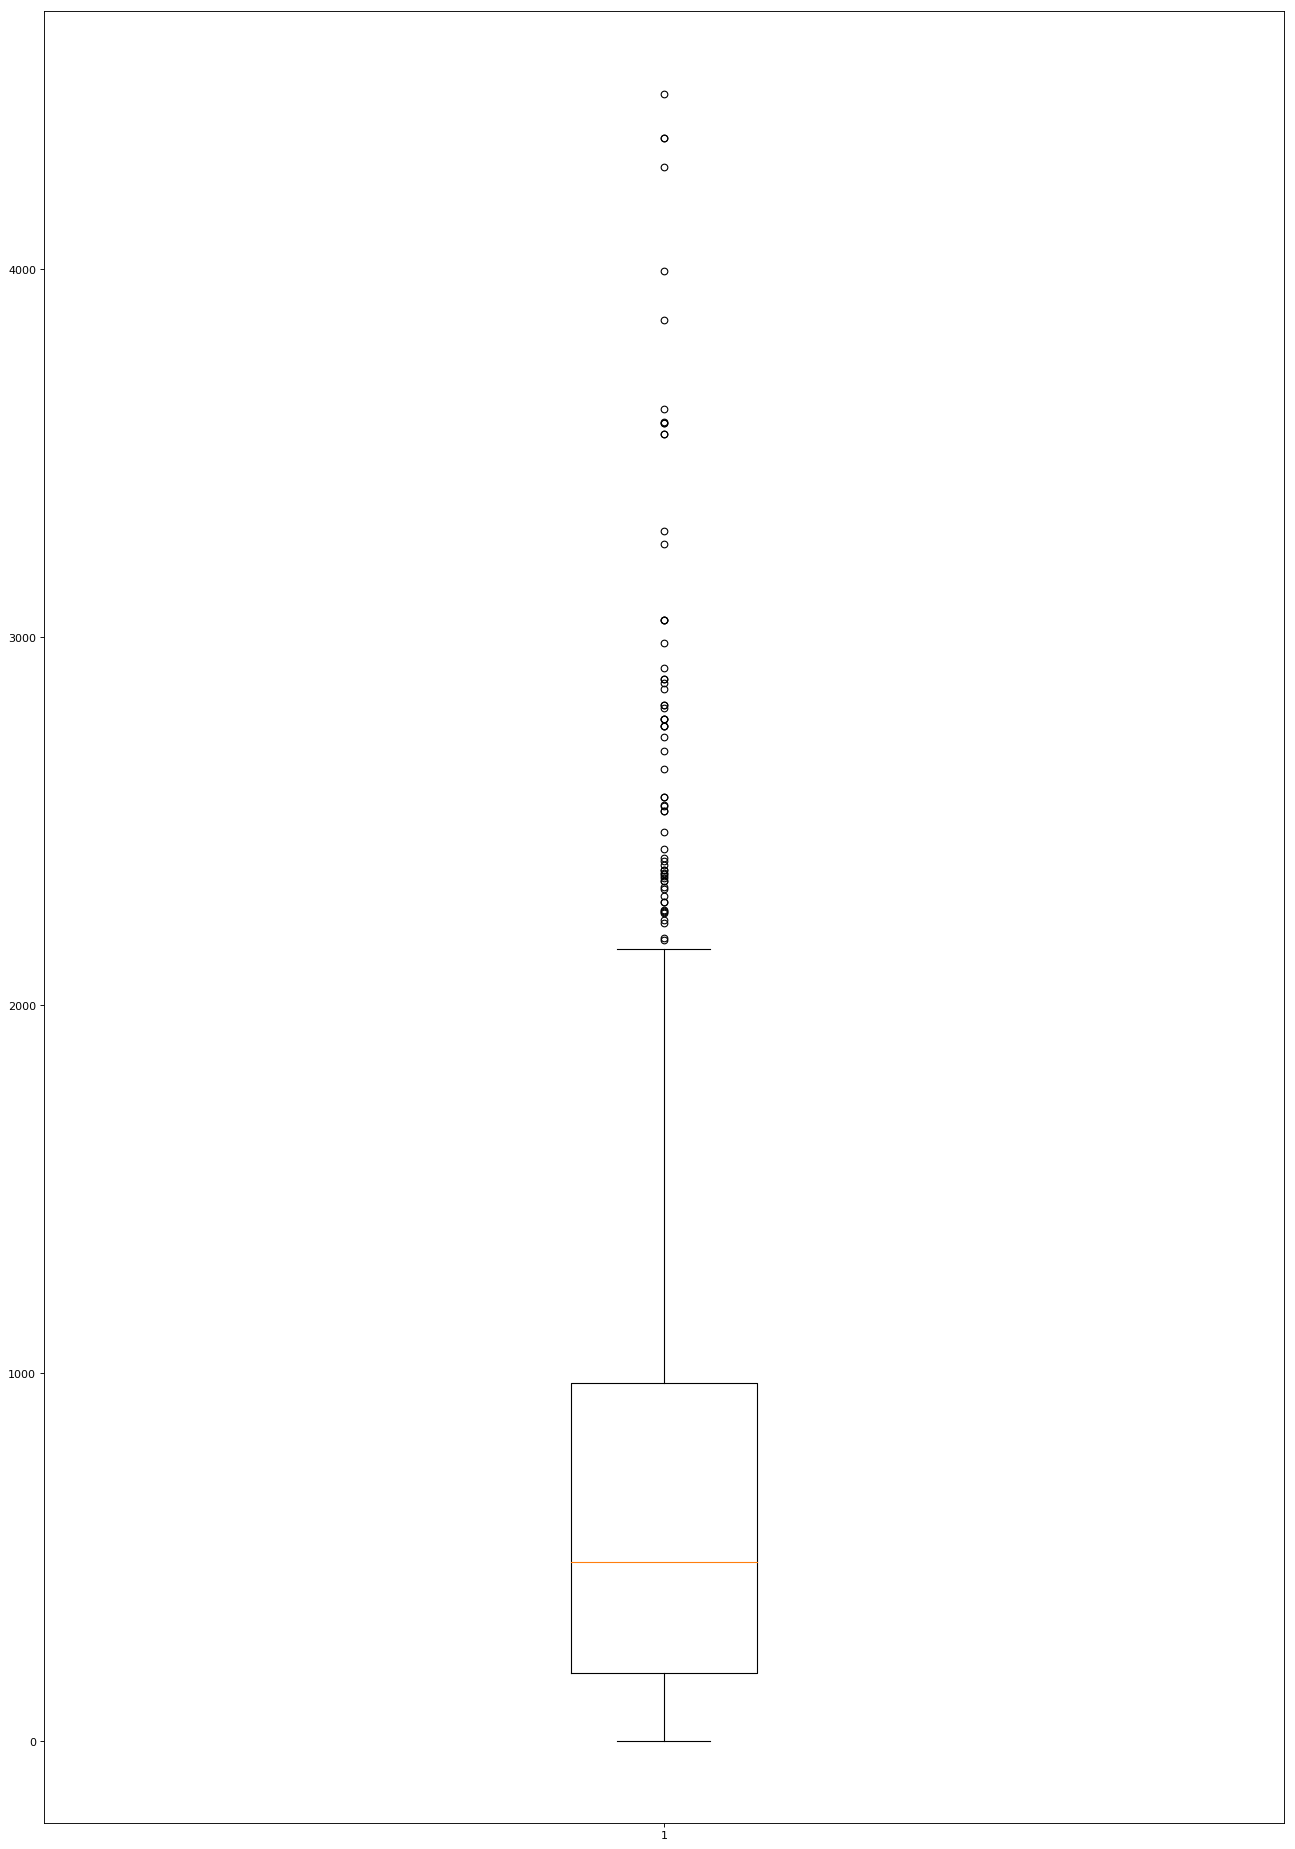

In [91]:
plt.figure(figsize=(20, 30), dpi=80)
plt.boxplot(y_train)

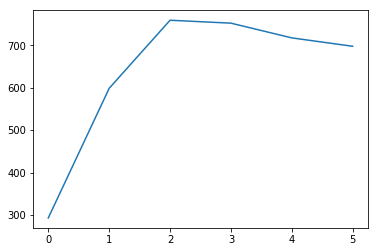

In [80]:
means = []
for i in range(6):
    means.append(y_train[(low_orders==i)].mean())
plt.plot(means)

In [81]:
y_train.mean()

664.6835836909871

In [93]:
np.percentile(y_train, 97)

2145.5824000000002

In [96]:
from scipy.stats import normaltest
normaltest(y_train)

NormaltestResult(statistic=799.0019939531057, pvalue=3.1544343857649184e-174)

NormaltestResult(statistic=162.78571610029007, pvalue=4.482609244981776e-36)
NormaltestResult(statistic=74.41875448444496, pvalue=6.921062779406201e-17)
NormaltestResult(statistic=136.96301867242187, pvalue=1.8149237459988036e-30)
NormaltestResult(statistic=148.1020233937164, pvalue=6.919173817347985e-33)
NormaltestResult(statistic=151.86135688110056, pvalue=1.0561493743391581e-33)
NormaltestResult(statistic=190.7561081443169, pvalue=3.783009411890936e-42)


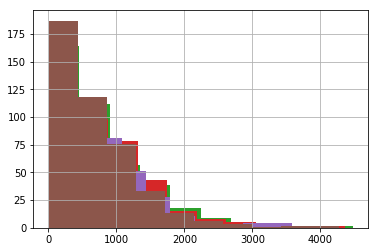

In [104]:
for i in range(6):
    print(normaltest(y_train[(low_orders==i)]))
    y_train[(low_orders==i)].hist()

In [105]:
["Закачка, м3","ГП(ИДН) Прирост дефита нефти","Вязкость нефти в пластовых условия","Закачка, м3","ГП(ИДН) Дебит жидкости скорр-ый",]

(2330,)

In [120]:
coef = pd.concat([train_cont, y_train_clean], axis=1).corr()

In [225]:
coef[coef>0.8]

,Ток номинальный,"Приемистость, м3/сут",Глубина верхних дыр перфорации,ГП(ИДН) Прирост дефита нефти,объемный коэффициент,Нефтенасыщенная толщина,Пластовое давление начальное,ТП - SKIN,Низ,I X/X,"Обводненность (вес), %",Плотность воды,Давление на приеме,ГП - Забойное давление,"Добыча растворенного газа, м3",Забойное давление,V гель,ТП - Забойное давление,FCD,"Простой, ч",Наклон,ТП - JD опт.,Удельный коэффициент,М пр,JD,Буферное давление,Мощность ПЭД,Обводненность,ГП(ИДН) Дебит жидкости,Пластовое давление,Глубина спуска доп. оборудования,"Время работы, ч",Замерное забойное давление,КВЧ,Удлинение,М бр,Высота перфорации,Глубина спуска,Производительность ЭЦН,Плотность нефти,JD факт,Динамическая высота,Вязкость жидкости в пласт. условиях,Рпл Хорнер,Глубина текущего забоя,Вязкость нефти в пластовых условиях,К пр от стимуляции,Ноб,Газовый фактор,Xf,Частота,"Закачка, м3","Дебит попутного газа, м3/сут",Давление в линии,Конц,Плотность раствора глушения,Диаметр штуцера,Диаметр НКТ,ГП(ГРП) Дебит жидкости,ГП(ГРП) Дебит жидкости скорр-ый,"Попутный газ, м3",Глубина спуска.1,Эфф,Напор,ГП(ИДН) Дебит жидкости скорр-ый,Верх,Азимут,Диаметр экспл.колонны,Pпл,Диаметр дополнительного оборудования,Коэффициент продуктивности,Гель,Давление пластовое,Ток рабочий,k,Давление наcыщения,Затрубное давление,Нэф,V под,Температура пласта,Hf,Характеристический дебит жидкости,Wf,Время до псевдоуст-ся режима,Дата ввода в эксплуатацию,Дата запуска после КРС,Дата пуска,Дата ГРП,Дата останова,"Нефть, т"
Ток номинальный,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Приемистость, м3/сут",NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.924479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Глубина верхних дыр перфорации,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ГП(ИДН) Прирост дефита нефти,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.807586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.808090,NaN,NaN,NaN,NaN,NaN,0.838825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
объемный коэффициент,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.803059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Нефтенасыщенная толщина,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Пластовое давление начальное,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
coef["Нефть, т"][(coef["Нефть, т"]>=0.1)|(coef["Нефть, т"]<=-0.1)].index

In [258]:
coef["Нефть, т"]

Ток номинальный                         0.017563
Приемистость, м3/сут                    0.036124
Глубина верхних дыр перфорации          0.023858
ГП(ИДН) Прирост дефита нефти            0.163503
объемный коэффициент                    0.103888
Нефтенасыщенная толщина                 0.075228
Пластовое давление начальное           -0.009282
ТП - SKIN                               0.246883
Низ                                     0.002578
I X/X                                  -0.000535
Обводненность (вес), %                 -0.033096
Плотность воды                         -0.079535
Давление на приеме                      0.123338
ГП - Забойное давление                 -0.021175
Добыча растворенного газа, м3           0.853569
Забойное давление                       0.086615
V гель                                  0.058448
ТП - Забойное давление                 -0.017867
FCD                                    -0.042180
Простой, ч                             -0.026141
Наклон              

In [112]:
len(train_cont.columns)

89

In [114]:
y_train_clean.shape

(4516,)

In [228]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 231kB/s ta 0:00:01
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
implicit 0.3.6 requires h5py, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/anaconda2/envs/env/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


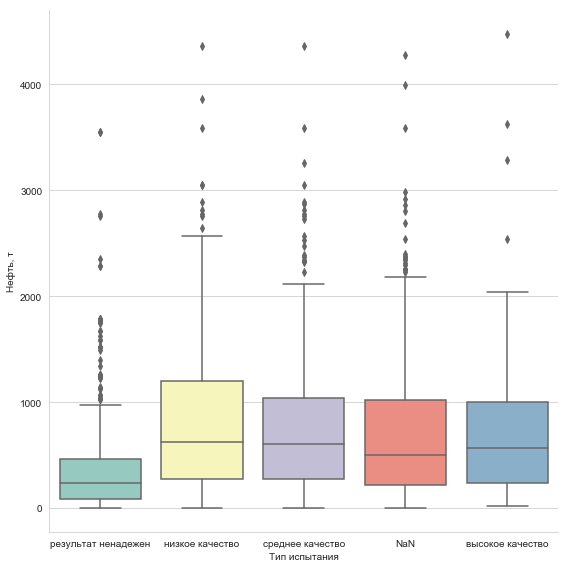

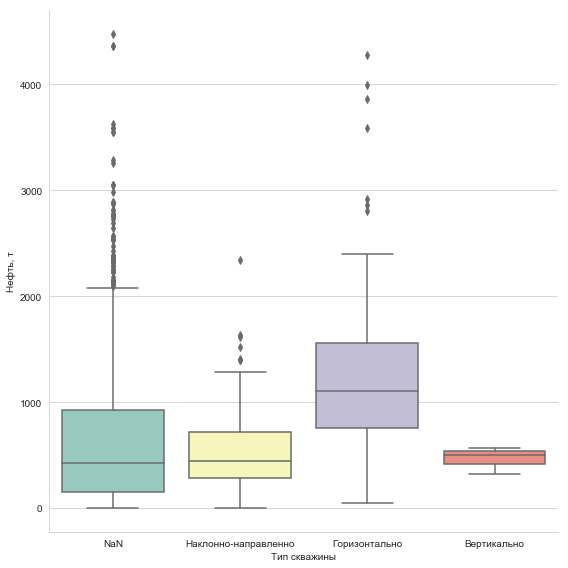

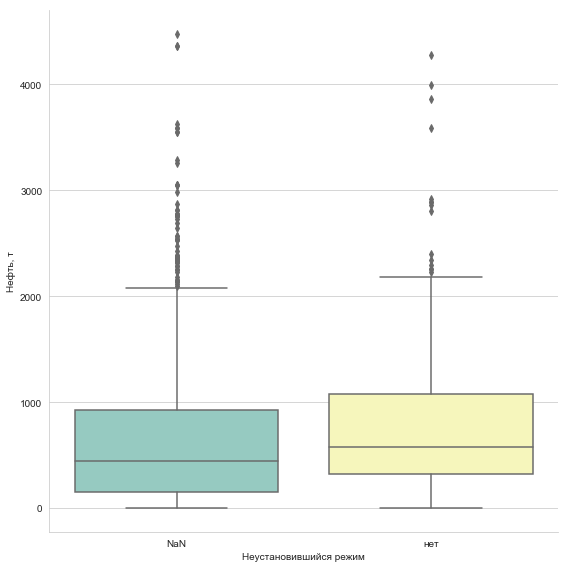

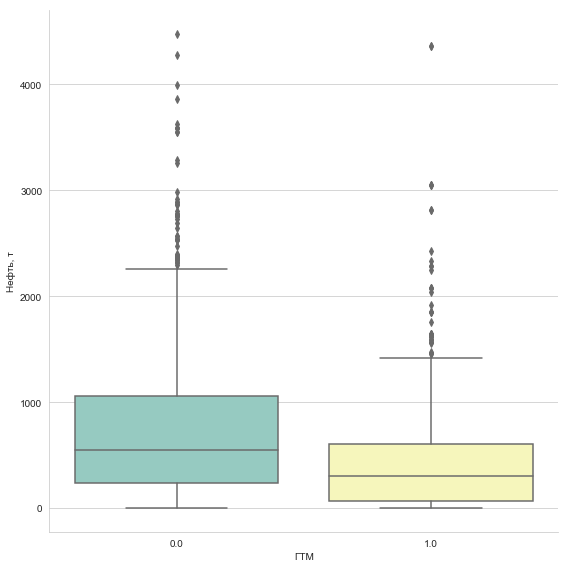

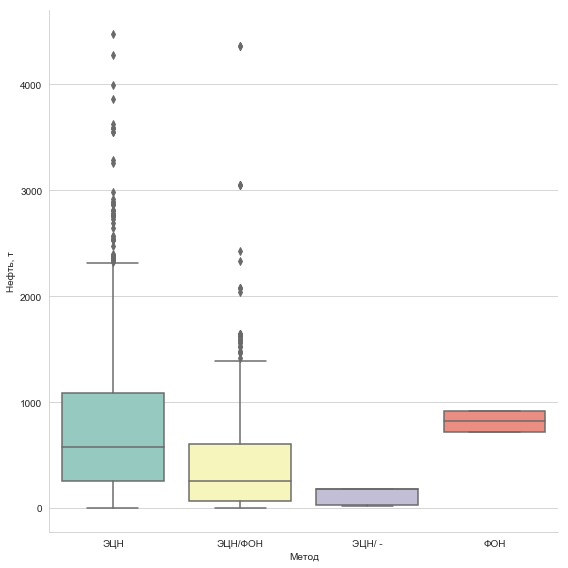

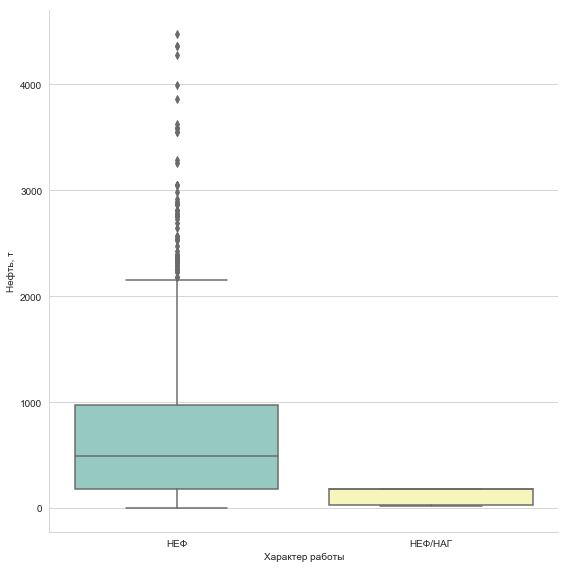

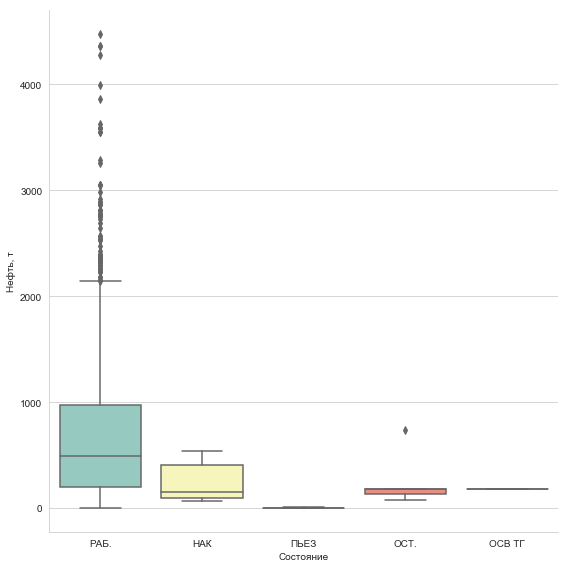

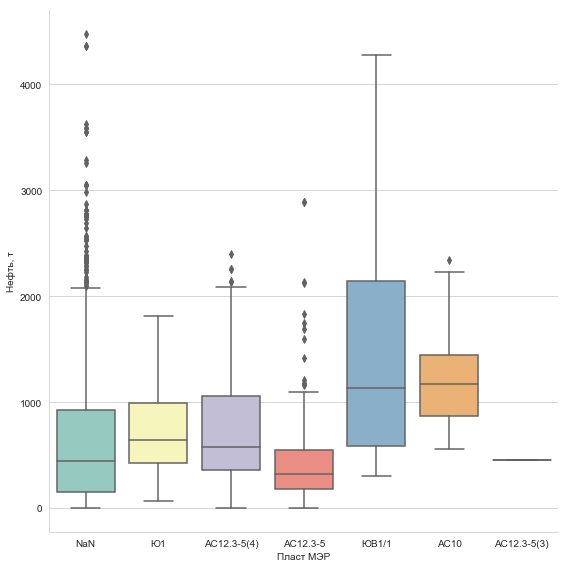

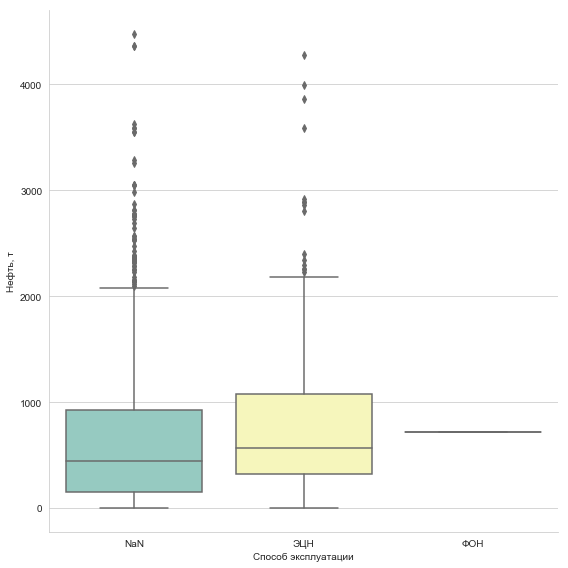

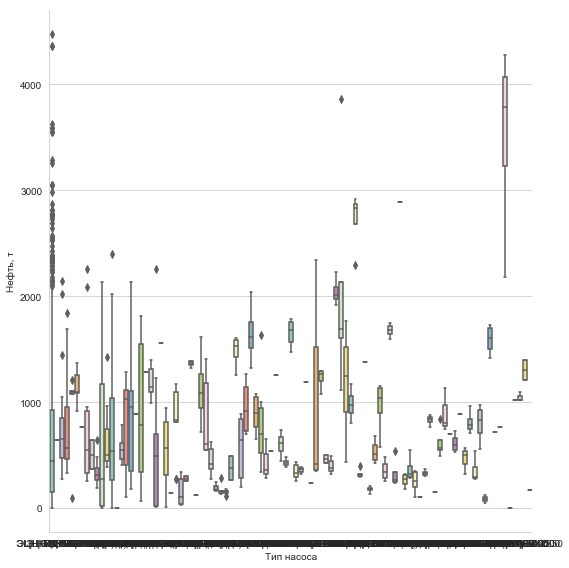

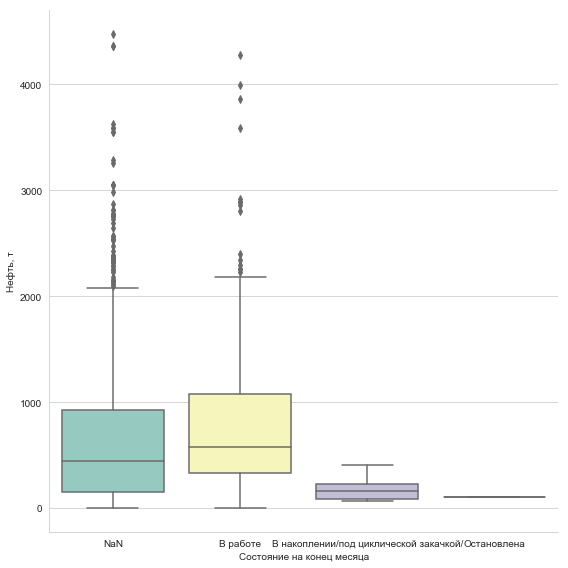

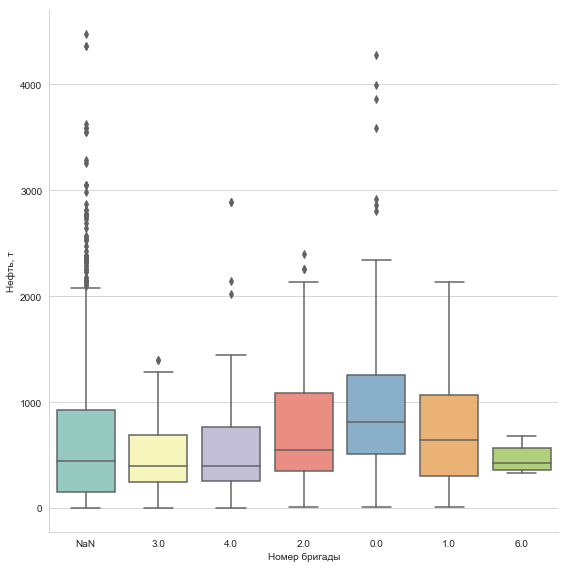

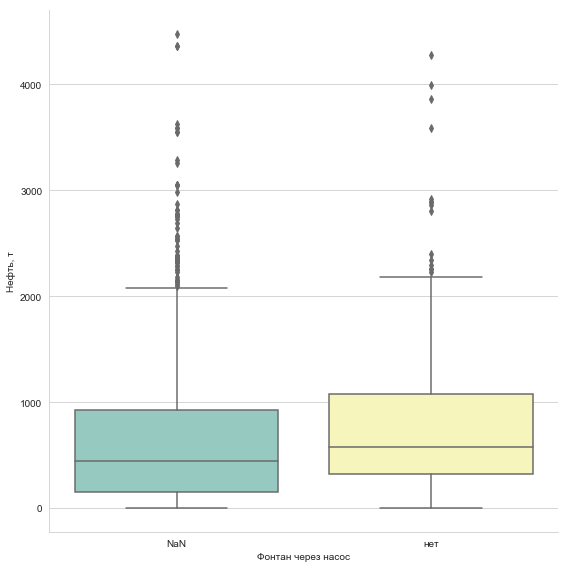

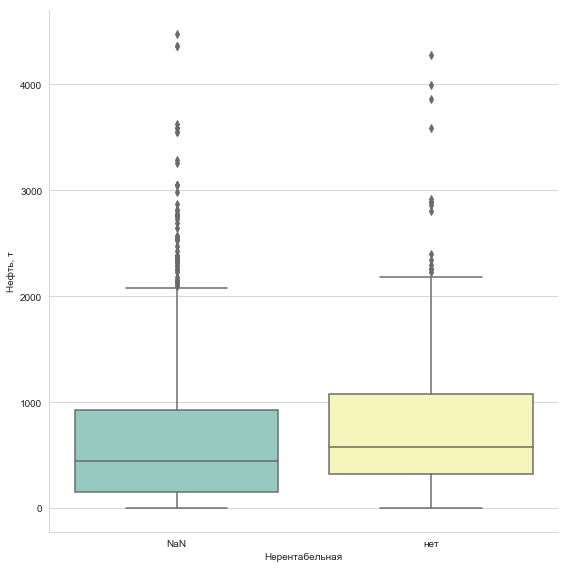

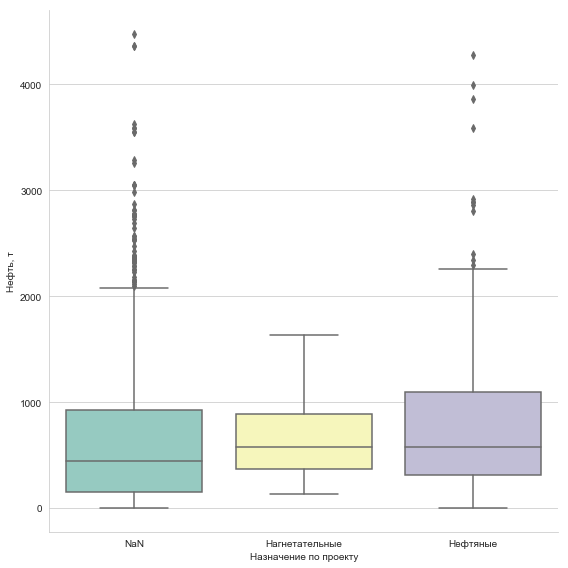

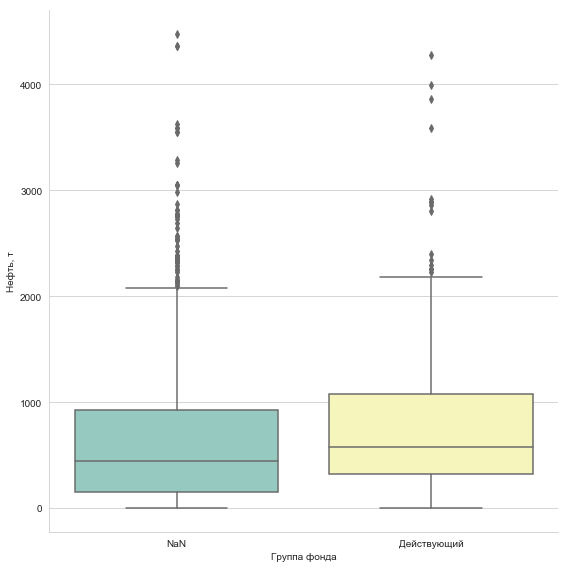

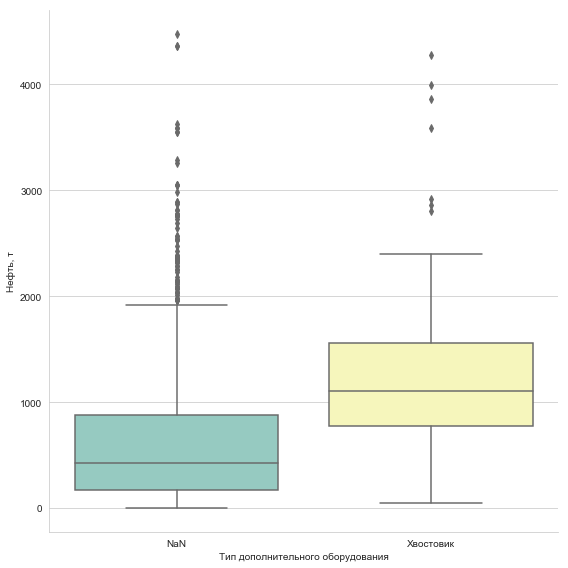

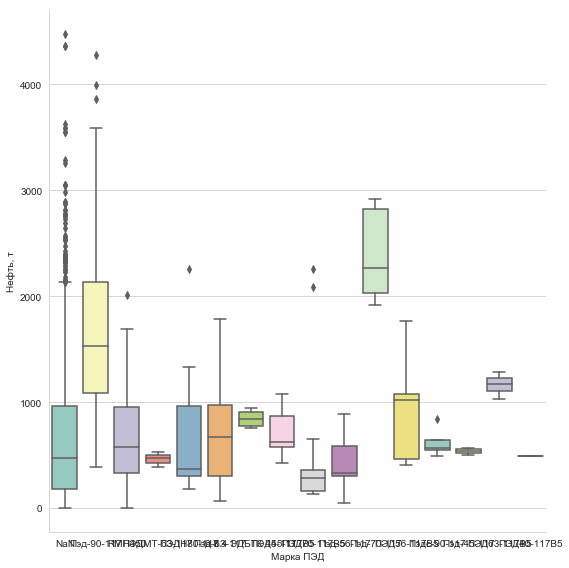

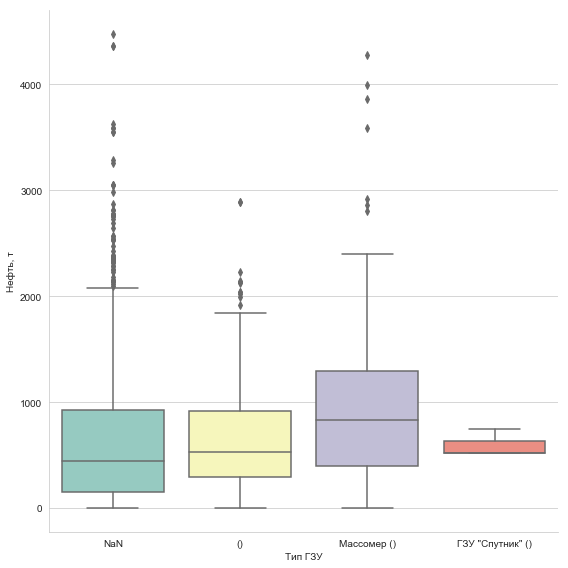

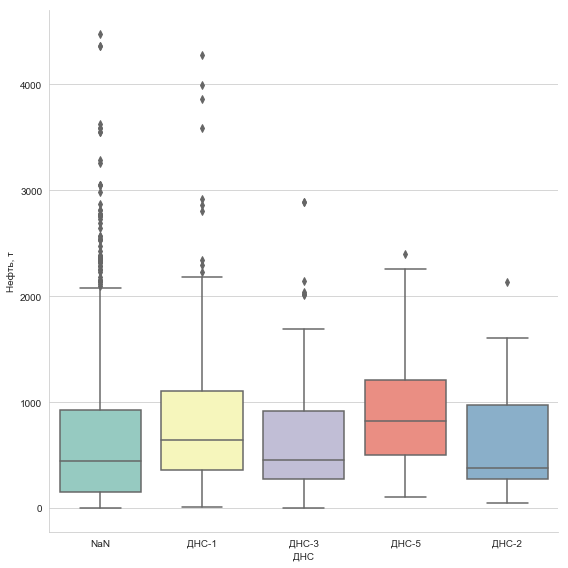

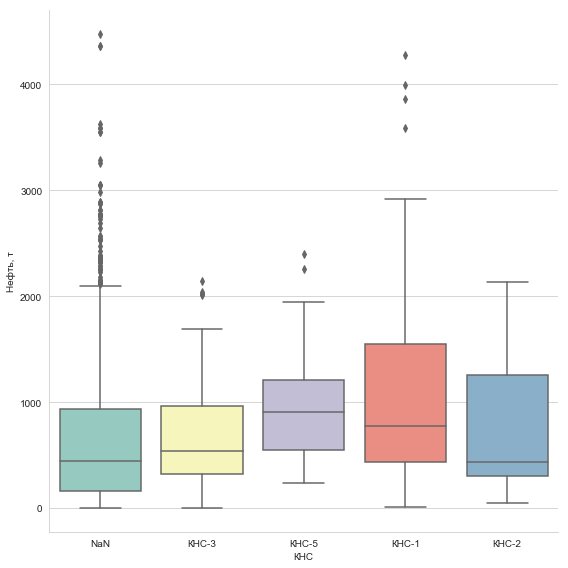

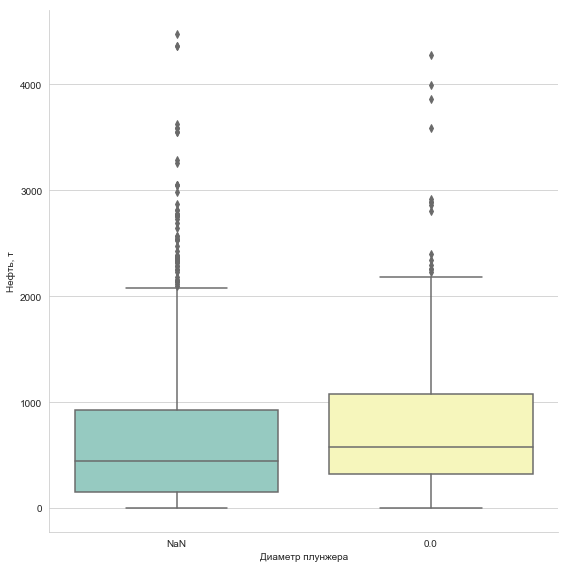

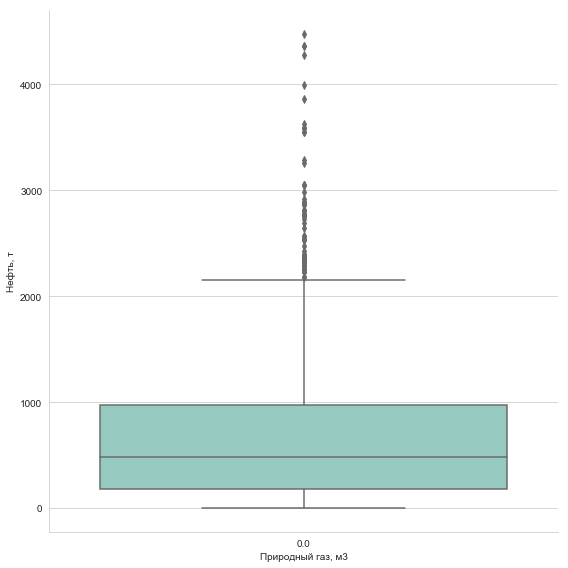

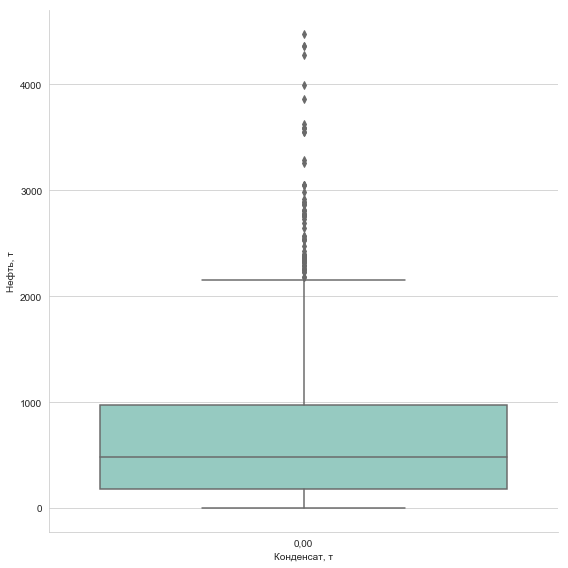

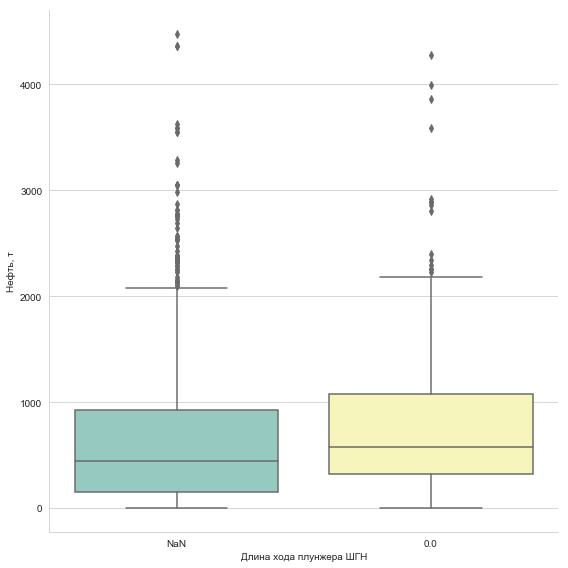

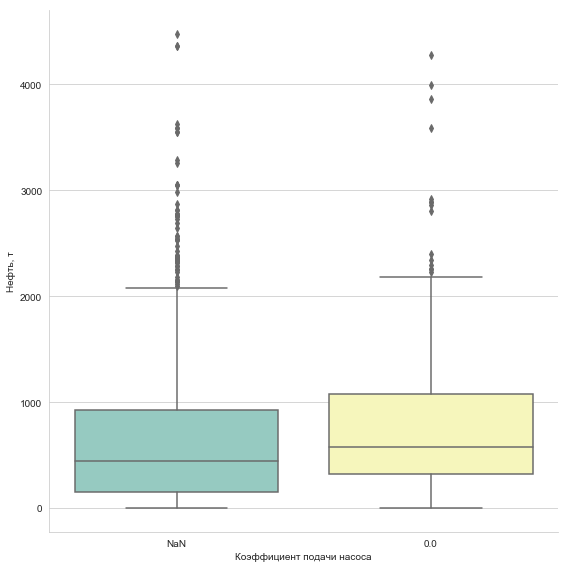

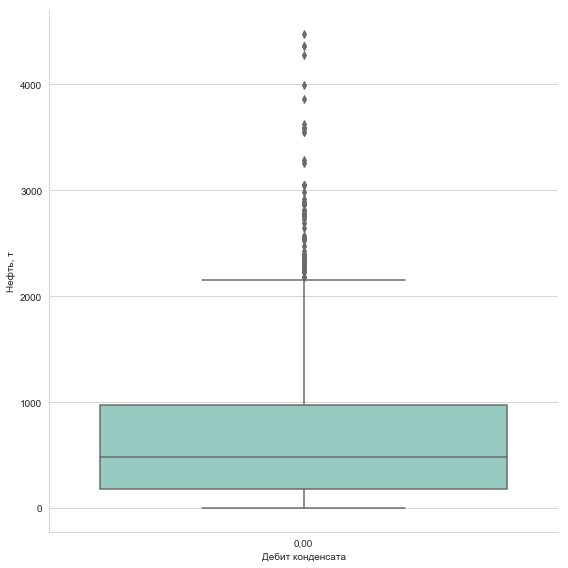

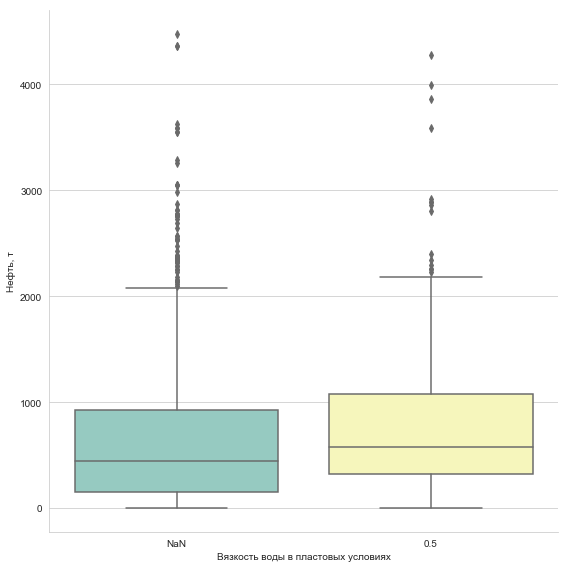

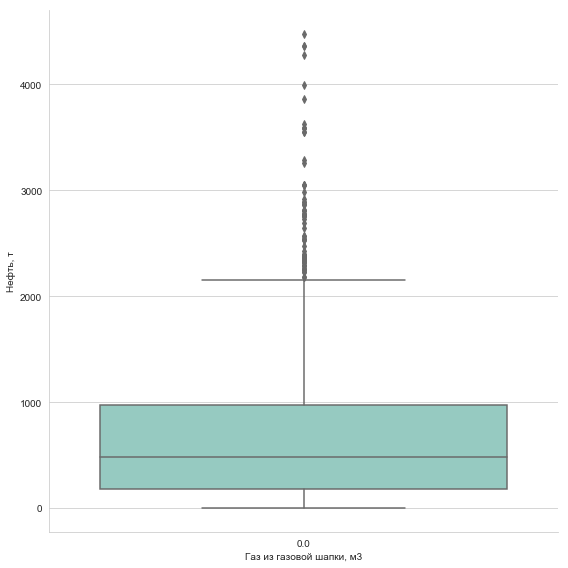

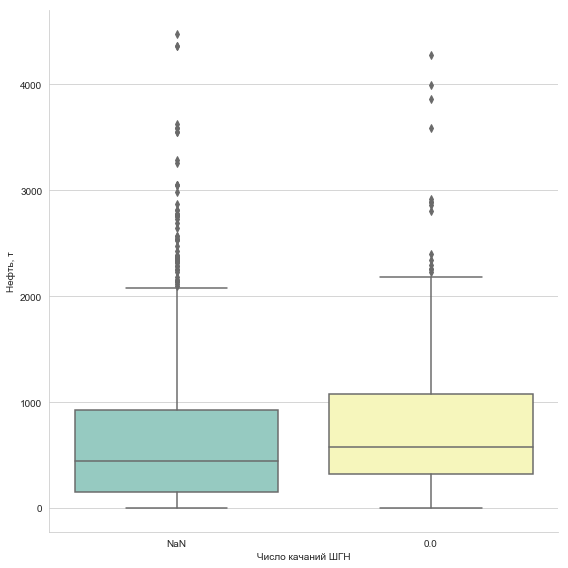

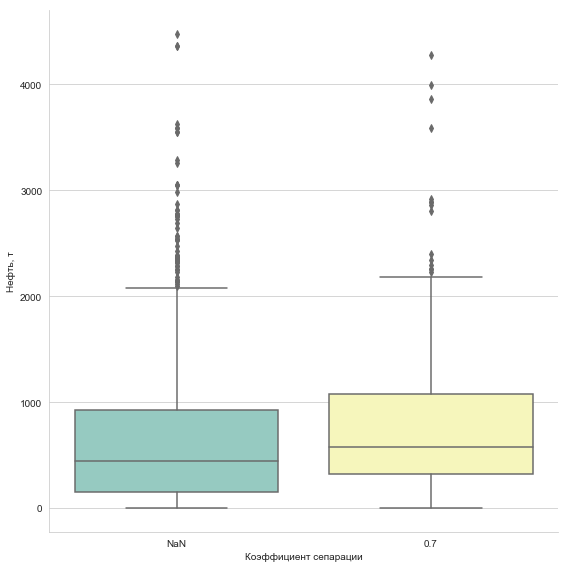

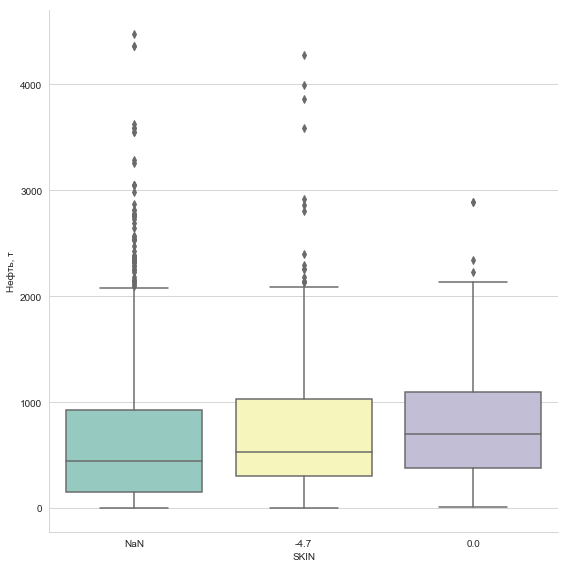

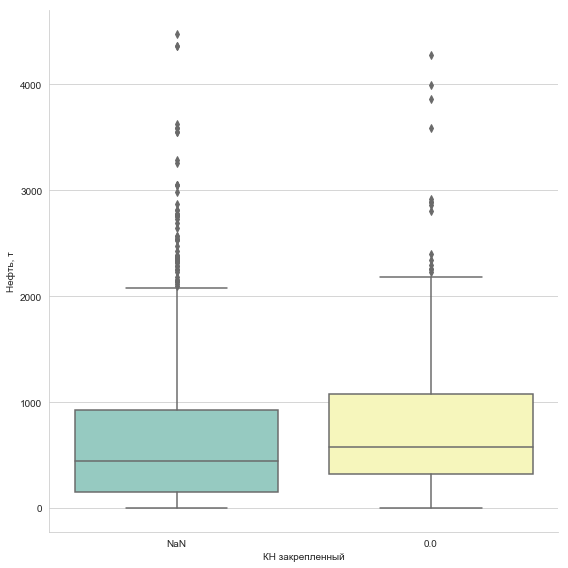

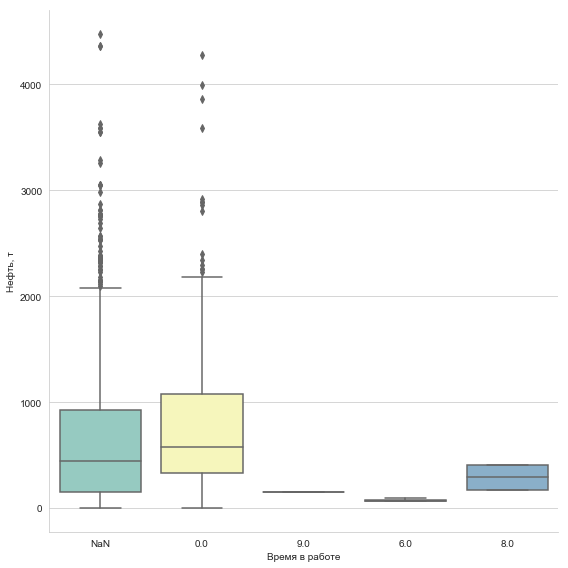

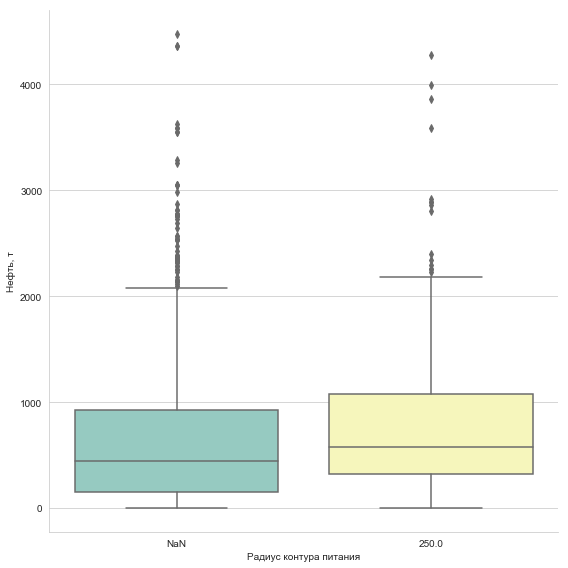

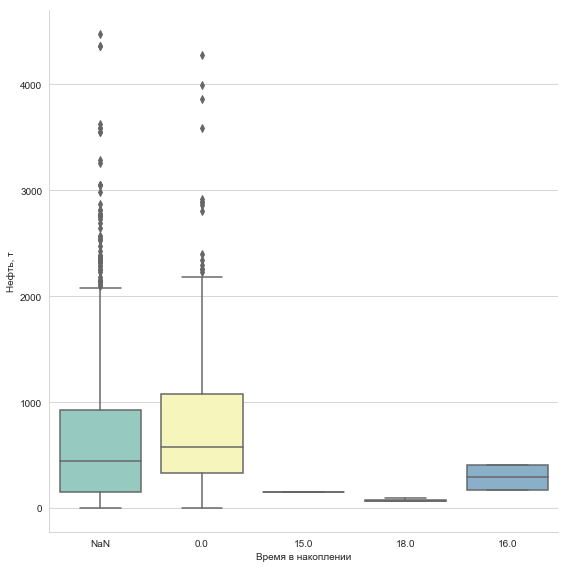

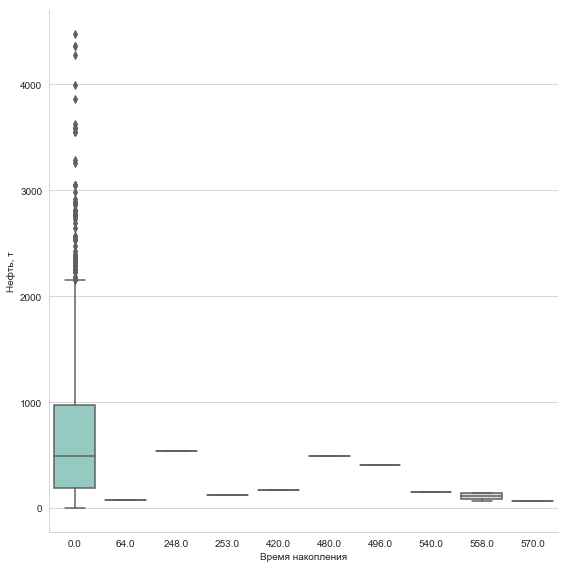

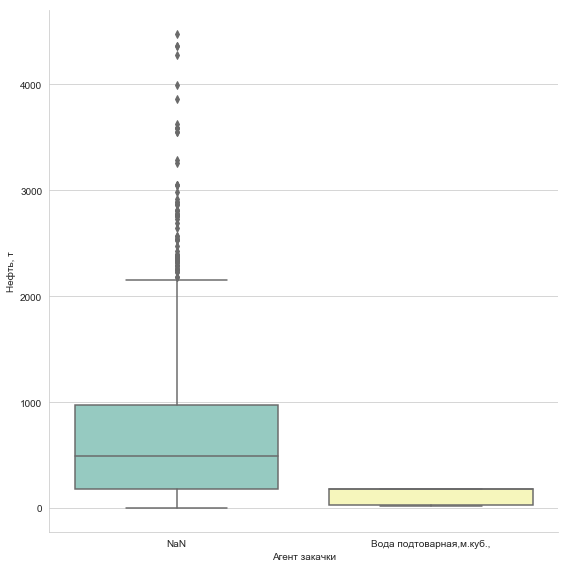

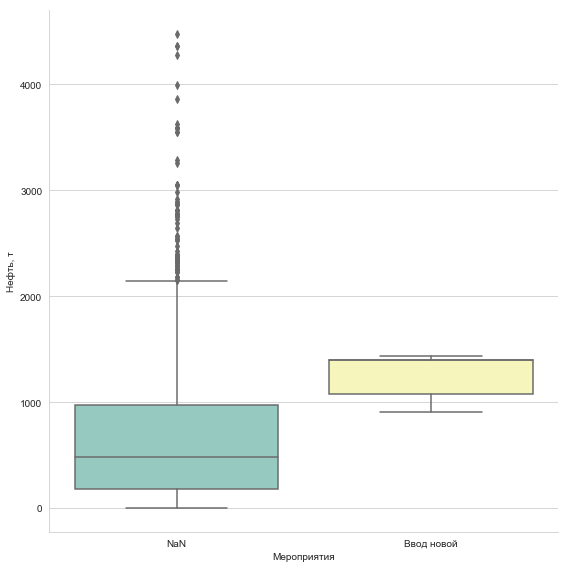

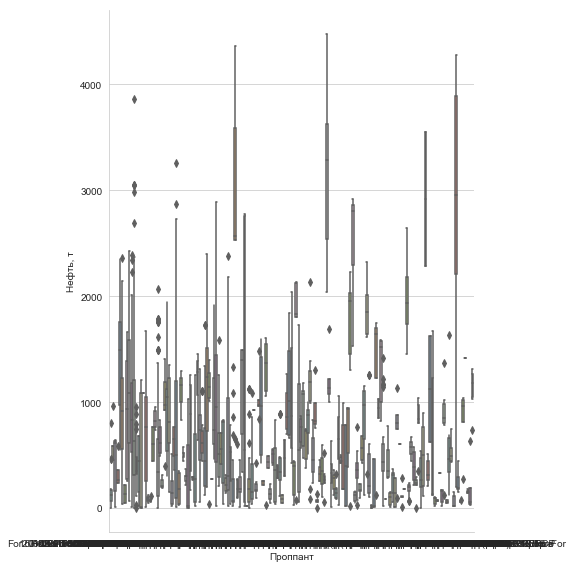

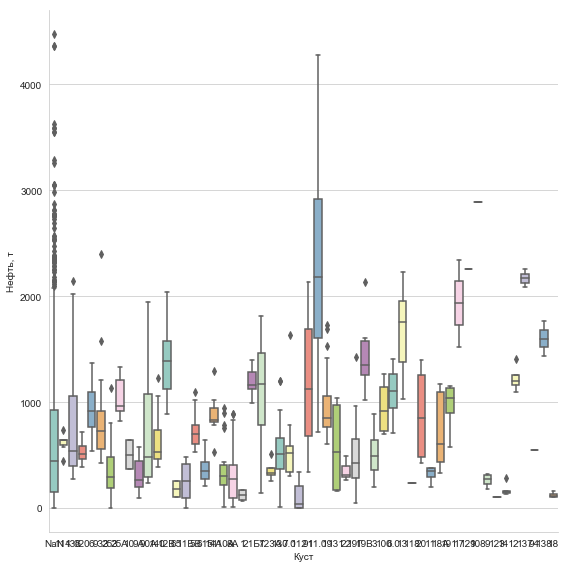

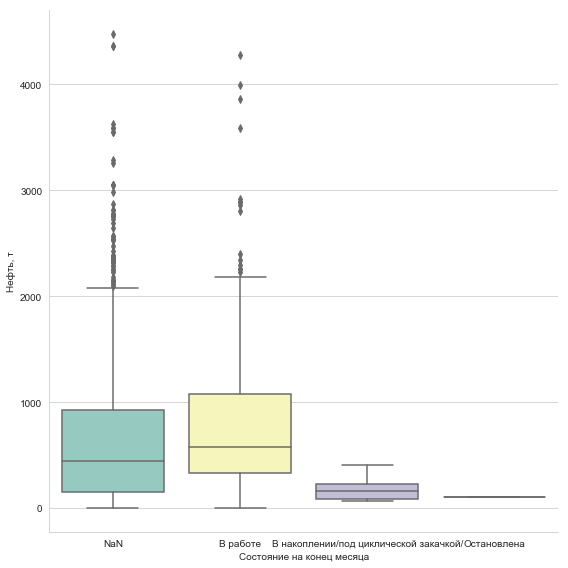

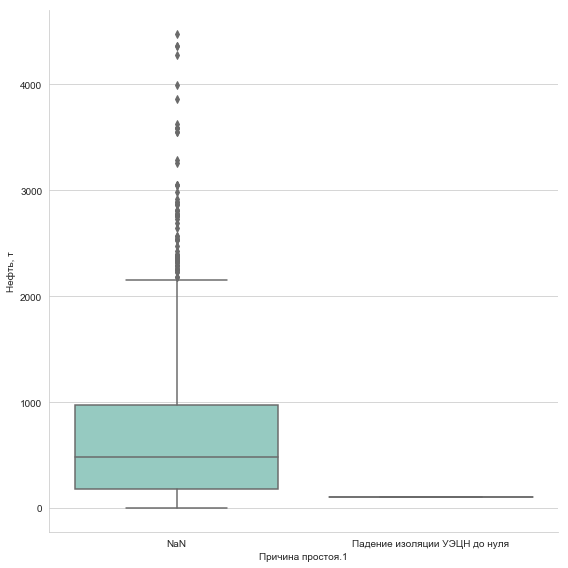

In [248]:
import seaborn as sns
sns.set_style("whitegrid")
cats = ["Тип испытания",
                   "Тип скважины",
                   "Неустановившийся режим",
                   "ГТМ",
                   "Метод",
                   "Характер работы",
                   "Состояние",
                   "Пласт МЭР", 
                   "Способ эксплуатации", 
                   "Тип насоса", 
                   "Состояние на конец месяца", 
                   "Номер бригады", 
                   "Фонтан через насос", 
                   "Нерентабельная",
                   "Назначение по проекту",
                   "Группа фонда",
                   "Тип дополнительного оборудования",
                   "Марка ПЭД",
                   "Тип ГЗУ",
                   "ДНС",
                   "КНС",
        #useless potentially
                   "Диаметр плунжера",
                   "Природный газ, м3",
                   "Конденсат, т",
                   "Длина хода плунжера ШГН",
                   "Коэффициент подачи насоса",
                   "Дебит конденсата",
                   "Вязкость воды в пластовых условиях",
                   "Газ из газовой шапки, м3",
                   "Число качаний ШГН",
                   "Коэффициент сепарации",
                   "SKIN",
                   "КН закрепленный",
                   # radically different
                   "Время в работе",
                   "Радиус контура питания",
                   "Время в накоплении",
                   "Время накопления",
                   "Агент закачки",
                   # text converted
                   "Мероприятия",
                   "Проппант",
                   "Куст",
                   "Состояние на конец месяца",
                   "Причина простоя.1",
       ]
for c in cats:
    data = pd.concat([train.iloc[y_train.index][c].fillna("NaN"), y_train], axis=1)
    ax = sns.catplot(x=c,y = "Нефть, т", data=data, palette="Set3",kind="box", size =8)

In [ ]:
#compare distributions, test, train, categorical, continious
#compare first day distribution of test and train
#prepare SVD solution

In [58]:
cont_columns = [                   'Высота перфорации',
                       'объемный коэффициент',
                    'Нефтенасыщенная толщина',
                            'Плотность нефти',
                                  'ТП - SKIN',
                        'Динамическая высота',
        'Вязкость жидкости в пласт. условиях',
                     'Глубина текущего забоя',
        'Вязкость нефти в пластовых условиях',
                                        'Ноб',
                             'Газовый фактор',
                             'Плотность воды',
                         'Давление на приеме',
                 'Замерное забойное давление',
                                    'Частота',
               'Дебит попутного газа, м3/сут',
              'Добыча растворенного газа, м3',
                                       'Конц',
                          'Забойное давление',
                'Плотность раствора глушения',
                            'Диаметр штуцера',
                                     'V гель',
                           'Попутный газ, м3',
                           'Глубина спуска.1',
                                     'Наклон',
                               'ТП - JD опт.',
                            'КН закрепленный',
                       'Удельный коэффициент',
                                        'Pпл',
       'Диаметр дополнительного оборудования',
                 'Коэффициент продуктивности',
                                       'Гель',
                         'Давление пластовое',
                                          'k',
                         'Давление наcыщения',
                     'ГП(ИДН) Дебит жидкости',
                                        'Нэф',
                                      'V под',
                         'Температура пласта',
           'Глубина спуска доп. оборудования',
                            'Время работы, ч',
          'Характеристический дебит жидкости',
                                        'КВЧ',
                                  'Удлинение',
               'Время до псевдоуст-ся режима',
                                 'Дата пуска',
                                   'Дата ГРП',
                              'Дата останова']
squared = []
for c1 in cont_columns:
    for c2 in cont_columns:
        squared.append(train_cont[c1].multiply(train_cont[c2]))
squared = pd.concat(squared, axis = 1)
#analyze squared correlation

NameError: name 'train_cont' is not defined

In [297]:
coef = pd.concat([squared, y_train_clean], axis=1).corr()

In [301]:
coef["Нефть, т"][coef["Нефть, т"]>0.4]

Дебит попутного газа, м3/сут     0.450203
720                              0.544092
726                              0.544157
767                              0.544092
Добыча растворенного газа, м3    0.541002
773                              0.541081
1049                             0.544157
1050                             0.541081
Попутный газ, м3                 0.541159
Нефть, т                         1.000000
Name: Нефть, т, dtype: float64

In [259]:
train["Дебит попутного газа, м3/сут"]

0         799,54
1        1289,68
2        1215,64
3        1046,26
4         914,06
5         757,05
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12          0,00
13       1423,76
14       2054,96
15       3318,09
16           NaN
17           NaN
18       3025,52
19        971,74
20        888,99
21       1154,01
22        930,19
23        853,62
24        679,03
25        679,03
26        832,80
27        832,80
28        794,63
29        794,63
30        652,12
31        652,12
32        672,21
33        672,21
34        594,56
35        594,56
36       1081,04
37       1163,47
38       1176,03
39       1137,63
40        955,96
41        732,36
42          0,00
43       1518,42
44       2276,87
45       2009,44
46       1948,97
47       1678,72
48        907,20
49        907,20
50       1941,87
51       1941,87
52       3064,16
53       3064,16
54       3396,71
55       3396,71
56       3248,58
57       3248,58
58       3224,

In [93]:
def  sqrt(x):
    if np.all(x>0):
        return np.sqrt(x)
    return 0
def reverse(x):
    if np.all(x!=0):
        return 1/x
    return 0

def log(x):
    if np.all(x>0):
        return np.log(x)
    return 0

transformations = {"log":log, 
                   "exp":np.exp, 
                   "sqrt":sqrt,
                   "sq":lambda x: x**2, 
                   "cube":lambda x:x**3,
                   "reverse":reverse,
                   "orig":lambda x:x}

def get_max_correlation(x,y):
    corr_coefs = []
    max_corr = 0
    max_corr_fn = ""
    for n,tf in transformations.items():
        x_tf = x.apply(tf)
        corr = y.corr(x_tf)
        if corr>max_corr:
            max_corr = corr
            max_corr_fn  = n
        corr_coefs.append((n, corr))
    return max_corr, max_corr_fn

In [94]:
get_max_correlation(train_cont["Плотность воды"], y_train_clean)

(0.08778822592267921, 'reverse')

In [96]:
for c in train_cont.columns:
    print(c)
    print(get_max_correlation(train_cont[c], y_train_clean))

Замерное забойное давление
(0.18331808448545214, 'sqrt')
ТП - JD опт.
(0, '')
index
(0.2017675948491305, 'sq')
КН закрепленный
(0, '')
Глубина спуска.1
(0.100877107344024, 'sqrt')
Добыча растворенного газа, м3
(0.8679859895516775, 'orig')
КВЧ
(0, '')
Давление пластовое
(0.02291843818354311, 'log')
Давление на приеме
(0.22179797620144004, 'sqrt')
Попутный газ, м3
(0.867985988080754, 'orig')
k
(0.18391529234781182, 'exp')
Диаметр штуцера
(0.08778822592287477, 'reverse')
Pпл
(0.07182730752659745, 'reverse')
Время работы, ч
(0.3547316465665551, 'orig')
Наклон
(0.2661683416151727, 'sqrt')
Газовый фактор
(0.08778822592287568, 'reverse')
Конц
(0.1155401269077244, 'sq')
Удлинение
(0.14828866151165065, 'sqrt')
Вязкость жидкости в пласт. условиях
(0.08792880488676265, 'log')
Глубина спуска доп. оборудования
(0.27080344041833077, 'sqrt')
Характеристический дебит жидкости
(0.24031667882605806, 'sqrt')
Плотность нефти
(0.08778822592285443, 'reverse')
Нэф
(0.17721029515748335, 'orig')
ТП - SKIN
(0.2

(0, '')
344
(0, '')
345
(0, '')
346
(0.0004675063685299174, 'exp')
347
(0, '')
348
(0, '')
349
(0, '')
350
(0.18592809832341942, 'exp')
351
(0.0051848372954585685, 'exp')
352
(0, '')
353
(0, '')
354
(0, '')
355
(0, '')
356
(0.01826646130051904, 'exp')
357
(0, '')
358
(0, '')
359
(0.05228321860820223, 'sqrt')
360
(0, '')
361
(0, '')
362
(0, '')
363
(0.01030229355107082, 'exp')
364
(0, '')
365
(0, '')
366
(0, '')
367
(0, '')
368
(0, '')
369
(0, '')
370
(0, '')
371
(0, '')
372
(0.013604712581682778, 'sqrt')
373
(0.004988374032312081, 'exp')
374
(0.040585382688508705, 'sqrt')
375
(0.03406124644271764, 'sqrt')
376
(0.037092029995860316, 'exp')
377
(0, '')
378
(0, '')
379
(0, '')
380
(0.14805718816353322, 'sqrt')
381
(0, '')
382
(0, '')
383
(0, '')
384
(0, '')
385
(0.024713068997806734, 'exp')
386
(0.037204742749273614, 'sqrt')
387
(0, '')
388
(0, '')
389
(0, '')
390
(0, '')
391
(0.019596064681952897, 'exp')
392
(0, '')
393
(0, '')
394
(0, '')
395
(0.06110473119886651, 'sqrt')
396
(0, '')
39

In [97]:
test["Добыча растворенного газа, м3"]

0             0
1           NaN
2           NaN
3          6929
4             0
5       9743,58
6           NaN
7         39598
8      53469,09
9             0
10            0
11            0
12            0
13        13651
14        15152
15            0
16            0
17     96932,82
18     16530,71
19            0
20        11608
21        11608
22        17280
23        17163
24            0
25     10029,35
26        34650
27       184550
28     20810,07
29        25603
30            0
31            0
32            0
33            0
34            0
35          NaN
36        28620
37        28620
38            0
39            0
40            0
41            0
42         1705
43          NaN
44          299
45          299
46        150,5
47          NaN
48            0
49          NaN
50            0
51          NaN
52          NaN
53            0
54            0
55      1919,12
56            0
57            0
58            0
59         5018
60        38805
61            0
62      